# LDA
- LDA, or Latent Dirichlet Allocation, is a statistical model used in natural language processing and machine learning for topic modeling. It is a generative probabilistic model that allows you to discover hidden topics in a large corpus of text data.

- The importance of LDA is that it allows you to identify the latent topics within a document or a collection of documents. This can be very useful in a number of applications such as content analysis, sentiment analysis, text classification, and information retrieval.

- The performance of LDA is typically evaluated using a variety of measures, such as perplexity, coherence, and topic diversity. Perplexity measures how well the model can predict new unseen documents, while coherence measures how well the topics generated by the model are interpretable and coherent. Topic diversity measures how different the topics are from each other.

- Interpreting the output of an LDA model involves looking at the most probable words associated with each topic and interpreting them. The topics generated by the model can then be labeled based on these words, and the results can be used to gain insights into the underlying themes in the corpus of text data.

In [76]:
# importing the libraries
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:
# loading the data
df = pd.read_pickle("/content/dataframe.pickle")

In [78]:
# Topics range
min_topics = 1
max_topics = 25

# The number of top words per topic
num_top_words = 10

# Initial random state
random_state = 42

# A row to use for verification of processing
verification_row = 9

In [79]:
df.head()

ROW_ID                                           FOI_TEXT  \
0  1969025  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...   
1  1426265  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
2  2609625  IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...   
3  2813837  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
4  1337517  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   

  DEVICE_PROBLEM_CODE             DEVICE_PROBLEM_TEXT  \
0                3283  Wireless Communication Problem   
1                3283  Wireless Communication Problem   
2                1435                No Device Output   
3                3283  Wireless Communication Problem   
4                3283  Wireless Communication Problem   

                 GENERIC_NAME DEVICE_REPORT_PRODUCT_CODE          UDI-DI  \
0  CONTINUOUS GLUCOSE MONITOR                        QBJ                   
1  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
2  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
3  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
4  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   

       UDI-PUBLIC DATE_OF_EVENT REPORTER_OCCUPATION_CODE REPORT_DATE  \
0                    07/30/2020                      000               
1  00386270000385    06/05/2020                      000               
2  00386270000385    10/05/2020                      000               
3  00386270000385    10/23/2020                      000               
4  00386270000385    05/25/2020                      000               

  EVENT_LOCATION SOURCE_TYPE  \
0              I    CONSUMER   
1              I    CONSUMER   
2              I    CONSUMER   
3              I    CONSUMER   
4              I    CONSUMER   

                                      TOKENIZED_TEXT  \
0  [it, was, reported, that, the, transmitter, lo...   
1  [it, was, reported, that, signal, loss, over, ...   
2  [it, was, reported, that, transmitter, failed,...   
3  [it, was, reported, that, signal, loss, over, ...   
4  [it, was, reported, that, signal, loss, over, ...   

                                        NOPUNCT_TEXT  \
0  [it, was, reported, that, the, transmitter, lo...   
1  [it, was, reported, that, signal, loss, over, ...   
2  [it, was, reported, that, transmitter, failed,...   
3  [it, was, reported, that, signal, loss, over, ...   
4  [it, was, reported, that, signal, loss, over, ...   

                                    NOSTOPWORDS_TEXT  \
0  [reported, transmitter, lost, connection, pump...   
1  [reported, signal, loss, one, hour, occurred, ...   
2  [reported, transmitter, failed, error, occurre...   
3  [reported, signal, loss, one, hour, occurred, ...   
4  [reported, signal, loss, one, hour, occurred, ...   

                                       NODIGITS_TEXT  \
0  [reported, transmitter, lost, connection, pump...   
1  [reported, signal, loss, one, hour, occurred, ...   
2  [reported, transmitter, failed, error, occurre...   
3  [reported, signal, loss, one, hour, occurred, ...   
4  [reported, signal, loss, one, hour, occurred, ...   

                                            POS_TEXT  \
0  [(reported, VBN), (transmitter, NN), (lost, VB...   
1  [(reported, VBN), (signal, JJ), (loss, NN), (o...   
2  [(reported, VBN), (transmitter, NN), (failed, ...   
3  [(reported, VBN), (signal, JJ), (loss, NN), (o...   
4  [(reported, VBN), (signal, JJ), (loss, NN), (o...   

                                     LEMMATIZED_TEXT  \
0  [report, transmitter, lose, connection, pump, ...   
1  [report, signal, loss, one, hour, occur, produ...   
2  [report, transmitter, fail, error, occur, data...   
3  [report, signal, loss, one, hour, occur, revie...   
4  [report, signal, loss, one, hour, occur, produ...   

                                        STEMMED_TEXT  
0  [report, transmitt, lost, connect, pump, great...  
1  [report, signal, loss, one, hour, occur, produ...  


In [80]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        'SENTENCE_ID',
        'SENTENCE', 
        'ROW_ID', 
        'FOI_TEXT', 
        'DEVICE_PROBLEM_CODE',
        'DEVICE_PROBLEM_TEXT'
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row['FOI_TEXT']):
        sentence_data = {
            'SENTENCE': sentence,
            'SENTENCE_ID': sentence_counter,
            'ROW_ID': row['ROW_ID'], 
            'FOI_TEXT': row['FOI_TEXT'], 
            'DEVICE_PROBLEM_CODE': row['DEVICE_PROBLEM_CODE'],
            'DEVICE_PROBLEM_TEXT': row['DEVICE_PROBLEM_TEXT']
        }
        sentences_df = sentences_df.append(sentence_data, ignore_index=True)
        sentence_counter = sentence_counter + 1        

In [81]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

punctuations = set(string.punctuation)

def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r'\b\d\w*\b', '', sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [token.translate(str.maketrans("", "", string.punctuation)) for token in sentence_tokens]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]
    
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence_tokens]
    
    # Rebuild the sentence
    sentence = ' '.join(lemmatized_tokens)

    return sentence

sentences_df['PROCESSED_SENTENCE'] = sentences_df['SENTENCE'].apply(process_sentence)

In [82]:
sentences_df['PROCESSED_SENTENCE']

0        report transmitter lose connection pump greate...
1            transmitter ultimately regain connection pump
2           additional patient event information available
3                        report signal loss one hour occur
4                          product data provide evaluation
                               ...                        
25681                    report signal loss one hour occur
25682                              data receive evaluation
25683    however allege product present within investig...
25684    confirmation allegation probable cause could d...
25685                   injury medical intervention report
Name: PROCESSED_SENTENCE, Length: 25686, dtype: object

In [83]:
# Tokenizing the text data in Processed_sentences
processed_docs = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: word_tokenize(x))

In [84]:
# Removing the stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
processed_docs = [[word for word in doc if word.lower() not in stop_words] for doc in processed_docs]

In [85]:
# Creating a dictionary of words and their frequency
dictionary = corpora.Dictionary(processed_docs)

# Filtering out words that appear in less than 5 documents, and more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Creating bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [86]:
# Building LDA model with varying number of topics
min_topics = 1
max_topics = 25
step_size = 1
coherence_scores = []
for num_topics in range(min_topics, max_topics+step_size, step_size):
    lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics,random_state=21, id2word=dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)
    print(f"Number of topics: {num_topics}, Coherence Score: {coherence_lda}")

# Creating DataFrame of number of topics and corresponding coherence score
df_coherence = pd.DataFrame({'num_topics': range(min_topics, max_topics+step_size, step_size), 'coherence_score': coherence_scores})

Number of topics: 1, Coherence Score: 0.4730657550960321
Number of topics: 2, Coherence Score: 0.3768952436075071
Number of topics: 3, Coherence Score: 0.36340462591610767
Number of topics: 4, Coherence Score: 0.36122466051794266
Number of topics: 5, Coherence Score: 0.41890968862998584
Number of topics: 6, Coherence Score: 0.3615796366288829
Number of topics: 7, Coherence Score: 0.3654185033725642
Number of topics: 8, Coherence Score: 0.39448788281928643
Number of topics: 9, Coherence Score: 0.38375261720267795
Number of topics: 10, Coherence Score: 0.4080668198941777
Number of topics: 11, Coherence Score: 0.39009701765828725
Number of topics: 12, Coherence Score: 0.385879739529299
Number of topics: 13, Coherence Score: 0.3910116707322667
Number of topics: 14, Coherence Score: 0.3932689661027494
Number of topics: 15, Coherence Score: 0.39461417324526427
Number of topics: 16, Coherence Score: 0.38438906988218574
Number of topics: 17, Coherence Score: 0.38808443846044194
Number of topic

In [87]:
df_coherence 

num_topics  coherence_score
0            1         0.473066
1            2         0.376895
2            3         0.363405
3            4         0.361225
4            5         0.418910
5            6         0.361580
6            7         0.365419
7            8         0.394488
8            9         0.383753
9           10         0.408067
10          11         0.390097
11          12         0.385880
12          13         0.391012
13          14         0.393269
14          15         0.394614
15          16         0.384389
16          17         0.388084
17          18         0.379719
18          19         0.404918
19          20         0.410346
20          21         0.385356
21          22         0.403099
22          23         0.434825
23          24         0.422261
24          25         0.421176

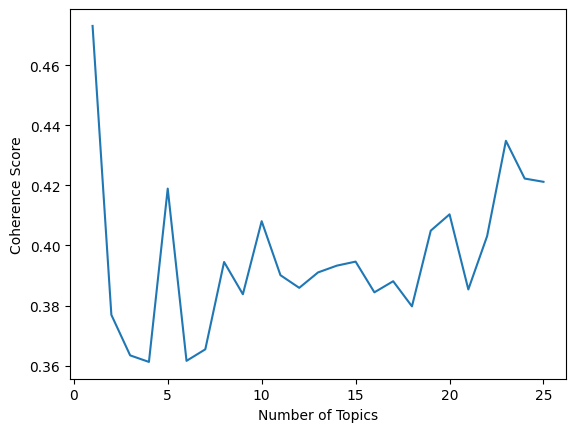

In [88]:
# Plotting the coherence score for each number of topics
x = range(min_topics, max_topics+step_size, step_size)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [89]:
# Printing the topics and their corresponding words
pprint(lda_model.show_topics(num_topics=5, num_words=10))

[(8,
  '0.200*"transmitter" + 0.167*"error" + 0.166*"fail" + 0.163*"report" + '
  '0.143*"occur" + 0.061*"customer" + 0.036*"send" + 0.036*"replacement" + '
  '0.015*"sensor" + 0.009*"receive"'),
 (12,
  '0.188*"report" + 0.174*"sensor" + 0.167*"occur" + 0.143*"expiration" + '
  '0.114*"early" + 0.057*"alert" + 0.031*"prematurely" + 0.027*"pair" + '
  '0.025*"message" + 0.022*"new"'),
 (3,
  '0.106*"find" + 0.103*"investigation" + 0.099*"within" + 0.099*"review" + '
  '0.098*"perform" + 0.097*"log" + 0.096*"window" + 0.095*"share" + '
  '0.089*"loss" + 0.064*"signal"'),
 (17,
  '0.194*"pass" + 0.193*"perform" + 0.186*"inspection" + 0.186*"visual" + '
  '0.149*"external" + 0.029*"externalexterior" + 0.010*"upper" + '
  '0.007*"receiver" + 0.007*"charge" + 0.006*"boot"'),
 (20,
  '0.334*"allegation" + 0.332*"confirm" + 0.156*"data" + 0.150*"evaluate" + '
  '0.010*"calibration" + 0.007*"potential" + 0.006*"misuse" + 0.003*"lead" + '
  '0.000*"periods" + 0.000*"accurate"')]


In [90]:
pd.option_context('display.max_colwidth', None)

In [91]:
# creating a dataframe with the top 10 words for each topic withou probability
topics_df = pd.DataFrame()

for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    # creating a list of the top 10 words for the topic
    top_words = [word for word, _ in topic]
    # adding the topic and top words to the dataframe
    topics_df = topics_df.append({'Topic': idx, 'Top Words': top_words}, ignore_index=True)



In [92]:
# creating a dataframe with the top 10 words and their probabilities for each topic
topics_df = pd.DataFrame()

for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    # creating a list of tuples containing the top 10 words and their probabilities for the topic
    top_words = [(word, round(prob, 4)) for word, prob in topic]
    # adding the topic and top words to the dataframe
    topics_df = topics_df.append({'Topic': idx, 'Top Words and Probabilities': top_words}, ignore_index=True)

print(topics_df)


    Topic                        Top Words and Probabilities
0       0  [(report, 0.1786), (hour, 0.1754), (loss, 0.16...
1       1  [(device, 0.1943), (however, 0.1642), (within,...
2       2  [(device, 0.1451), (receive, 0.1189), (system,...
3       3  [(find, 0.1059), (investigation, 0.1031), (wit...
4       4  [(medical, 0.2492), (report, 0.2489), (interve...
5       5  [(pair, 0.2513), (perform, 0.2046), (pass, 0.1...
6       6  [(cause, 0.2093), (determine, 0.209), (could, ...
7       7  [(evaluate, 0.2039), (product, 0.201), (multip...
8       8  [(transmitter, 0.2002), (error, 0.1674), (fail...
9       9  [(sensor, 0.2166), (b, 0.1832), (insert, 0.165...
10     10  [(perform, 0.1795), (voltage, 0.1639), (test, ...
11     11  [(report, 0.1316), (submit, 0.131), (new, 0.12...
12     12  [(report, 0.1885), (sensor, 0.1737), (occur, 0...
13     13  [(glucose, 0.1409), (report, 0.1025), (cgm, 0....
14     14  [(report, 0.3352), (occur, 0.2891), (sensor, 0...
15     15  [(connection,

Topic 0:


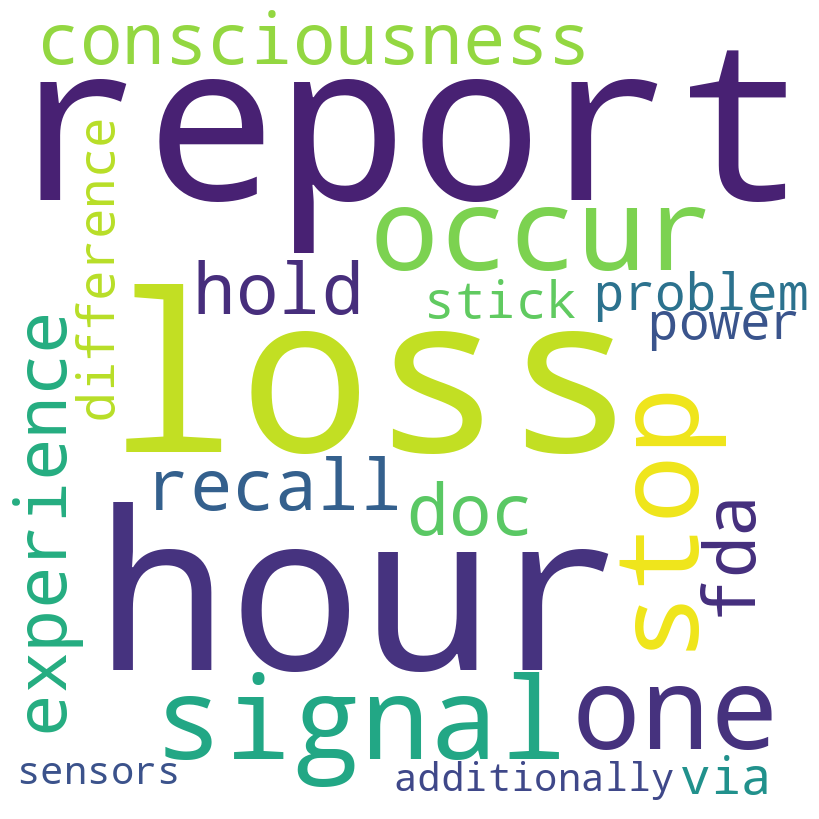

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 1:


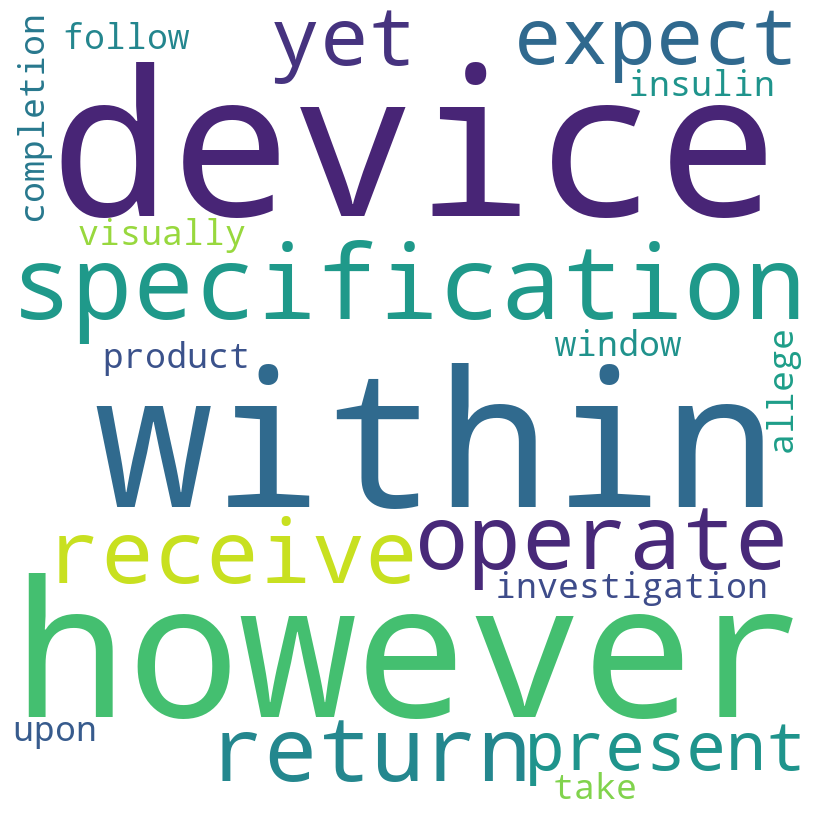

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 2:


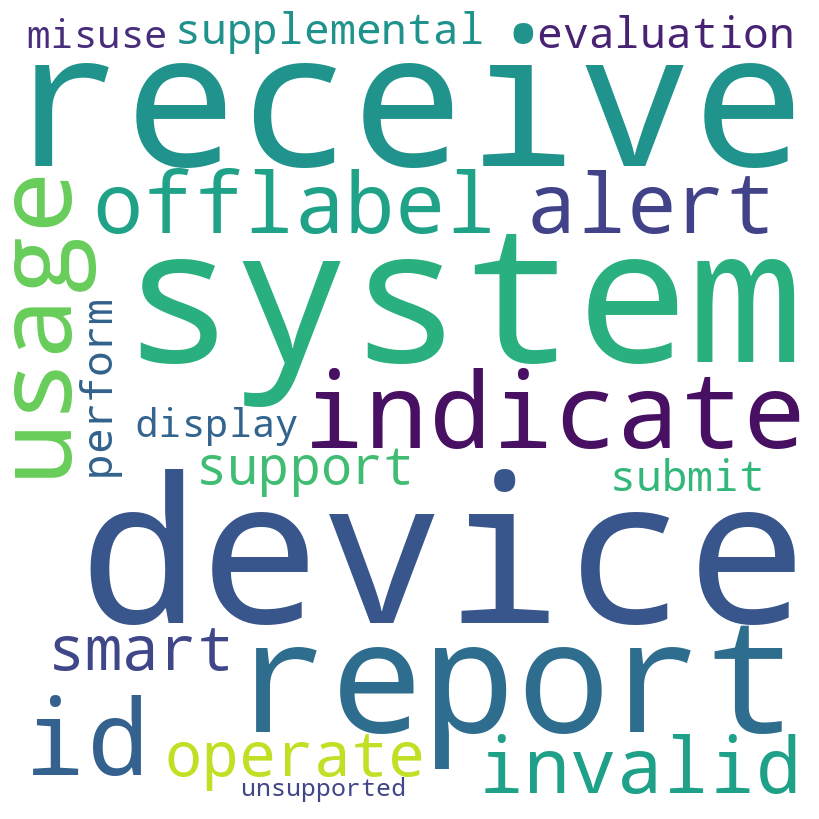

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 3:


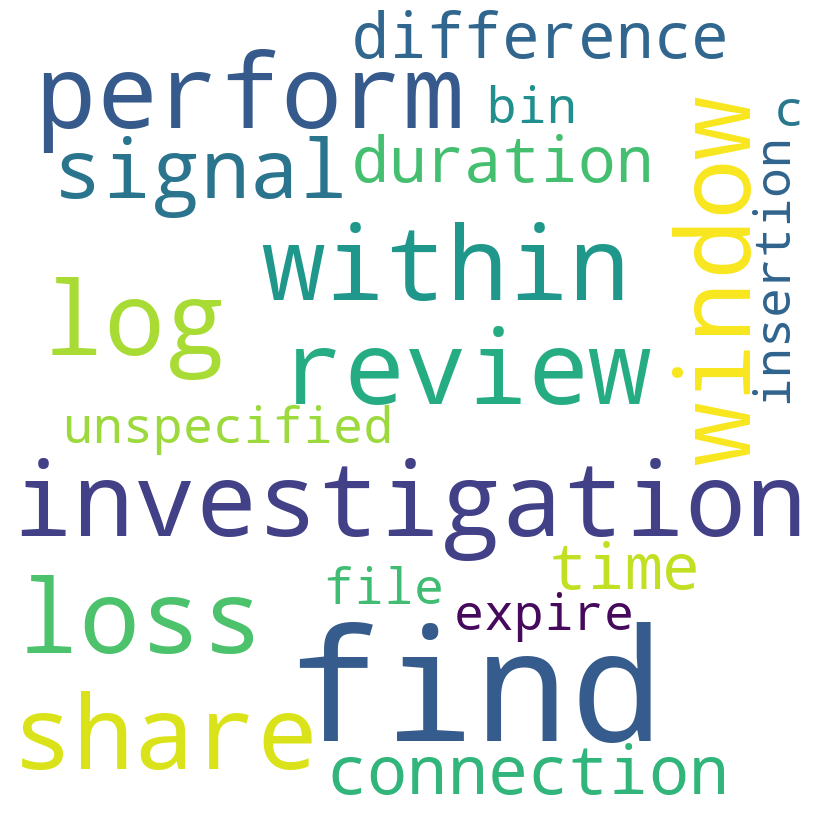

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 4:


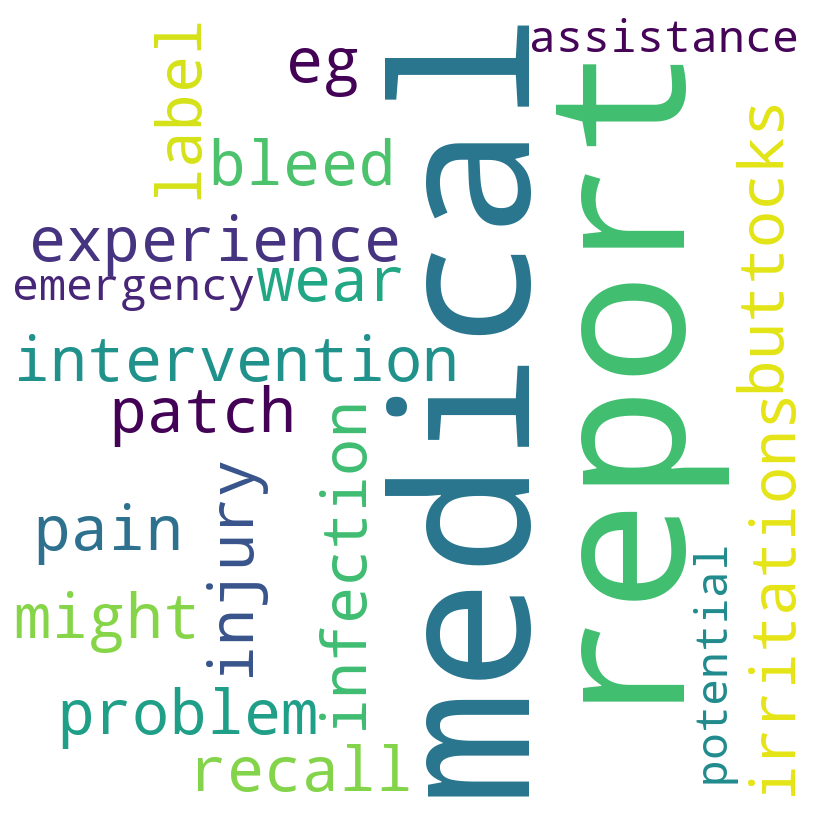

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 5:


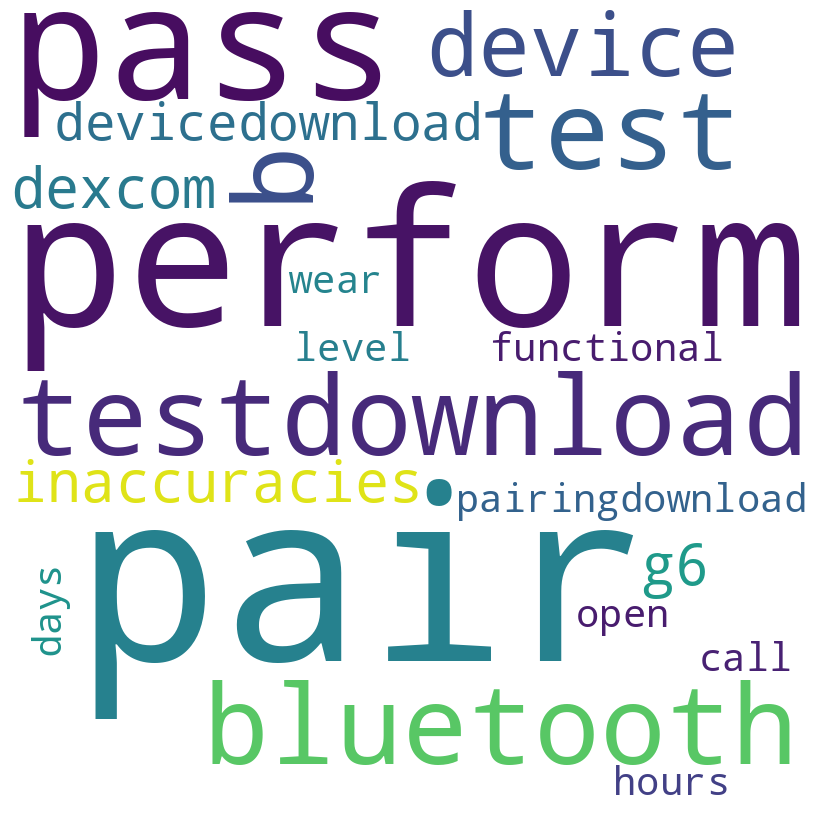

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 6:


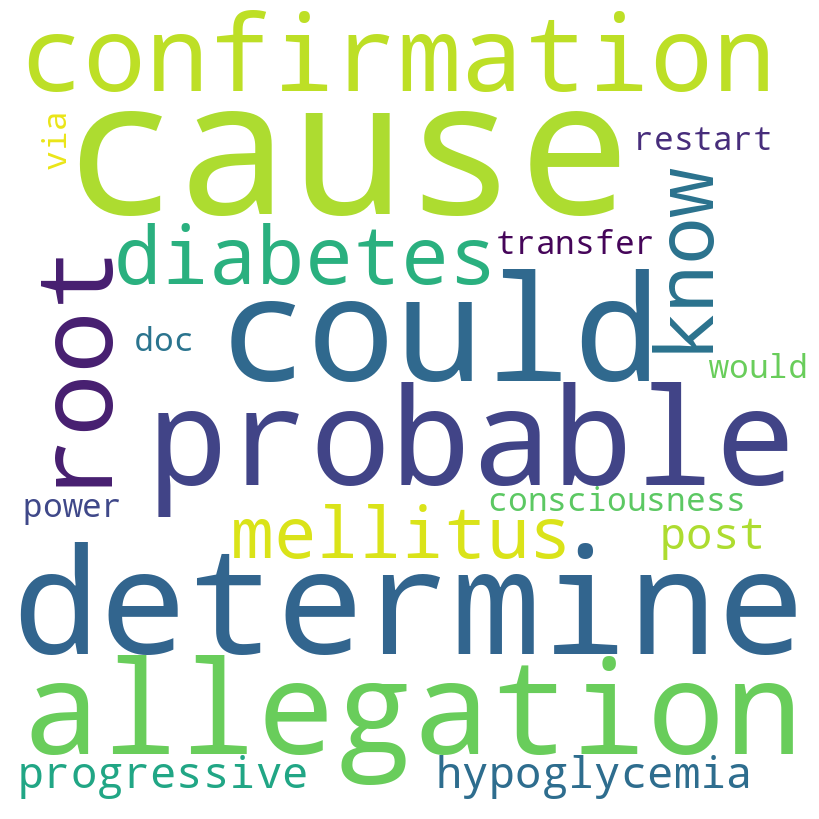

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 7:


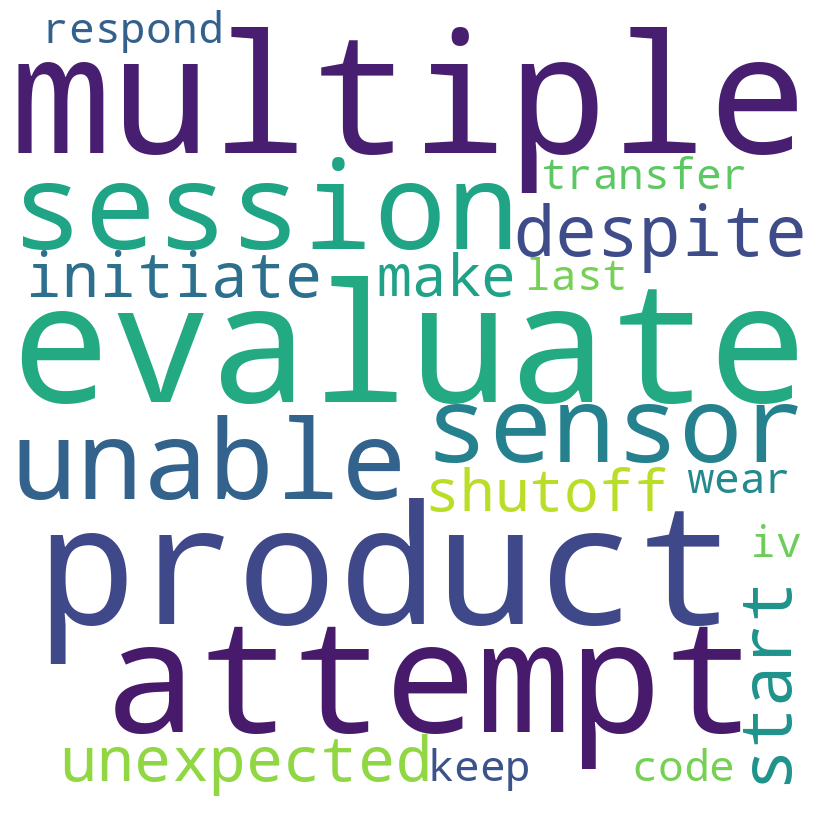

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 8:


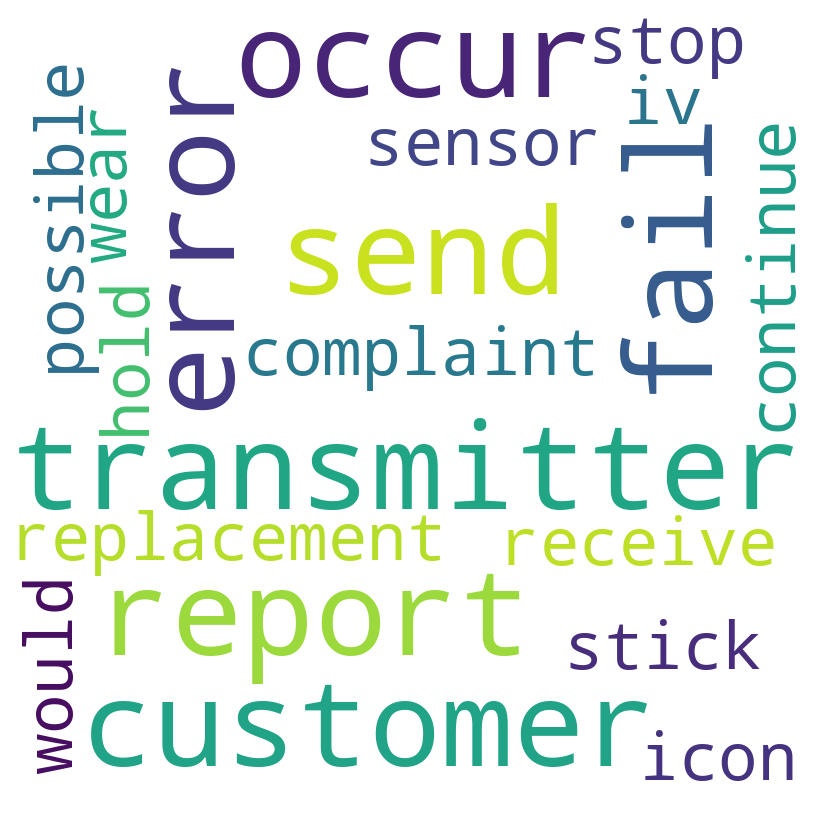

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 9:


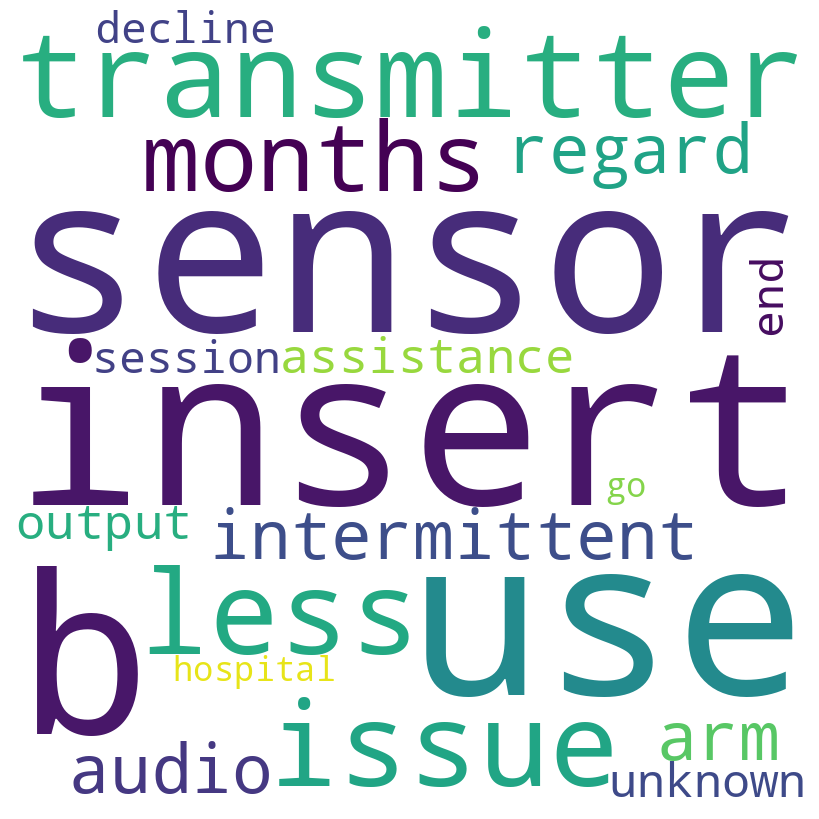

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 10:


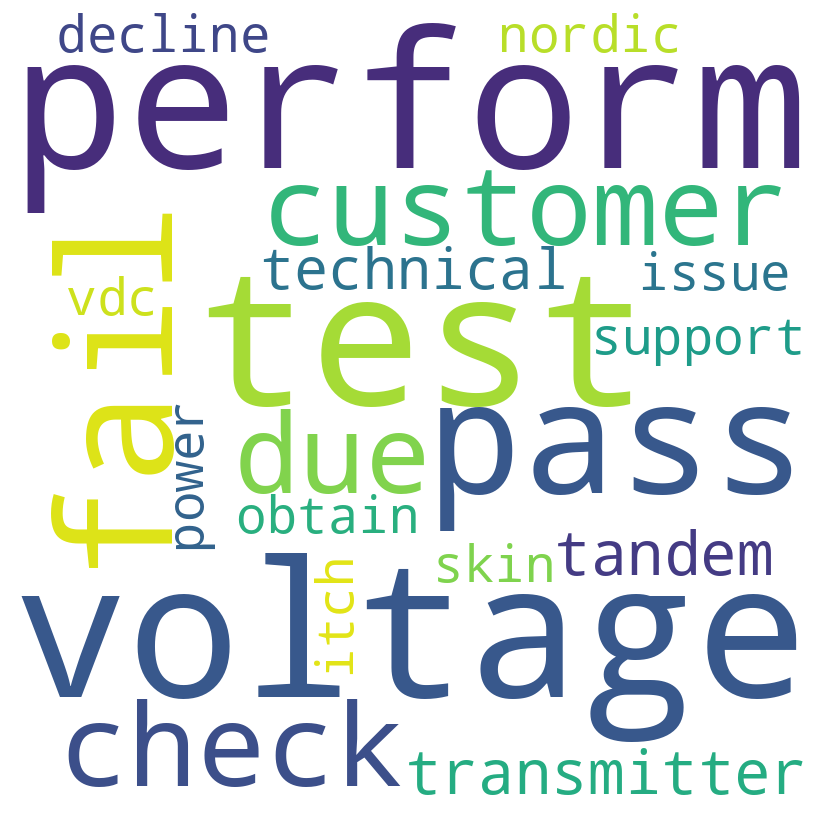

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 11:


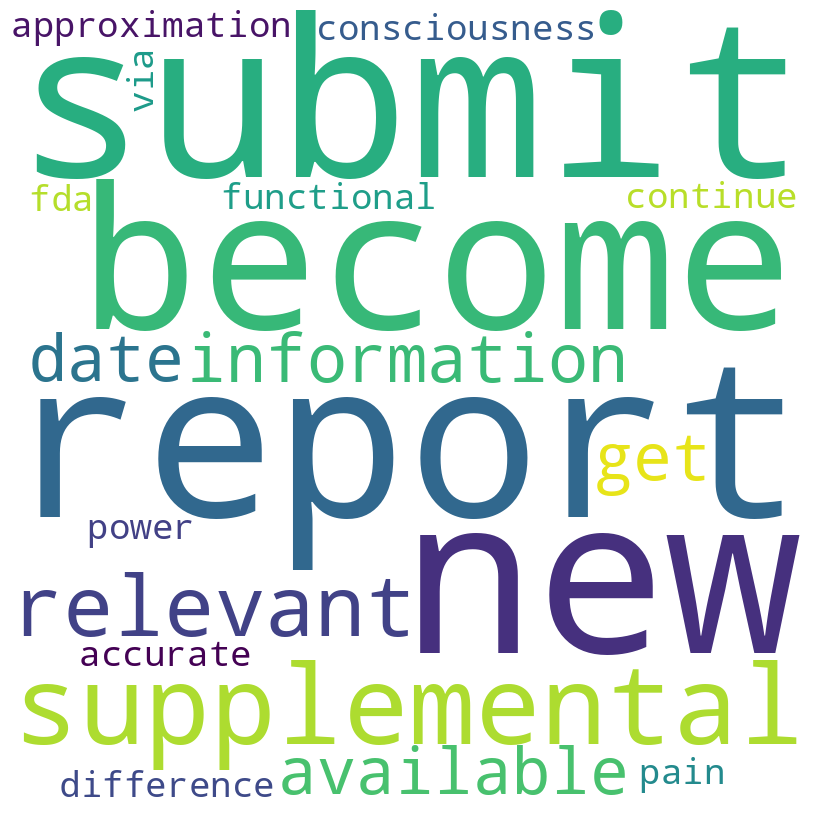

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 12:


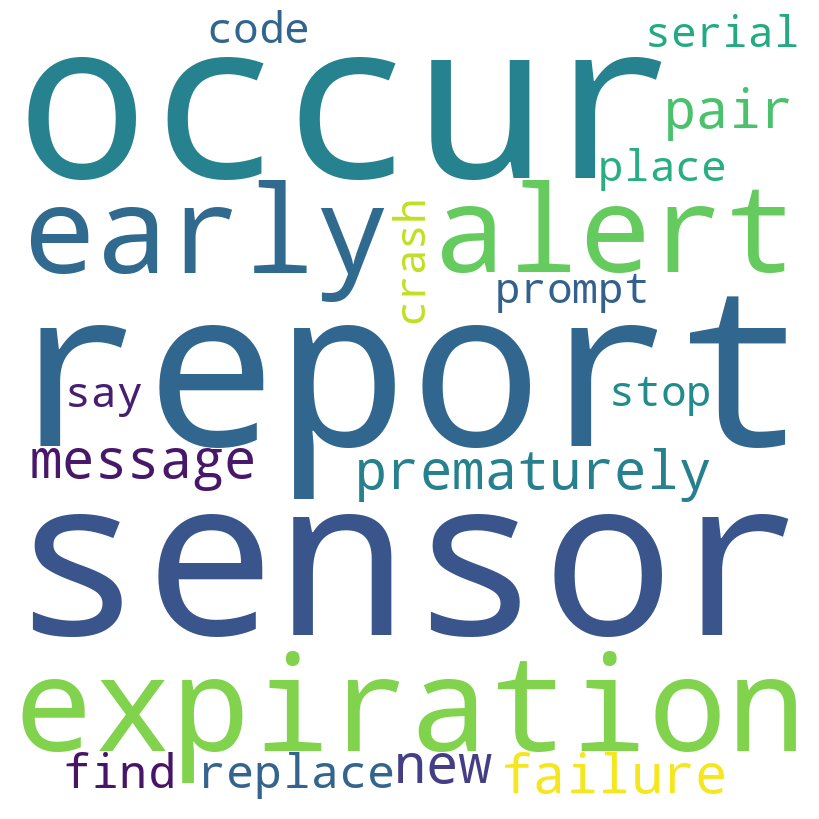

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 13:


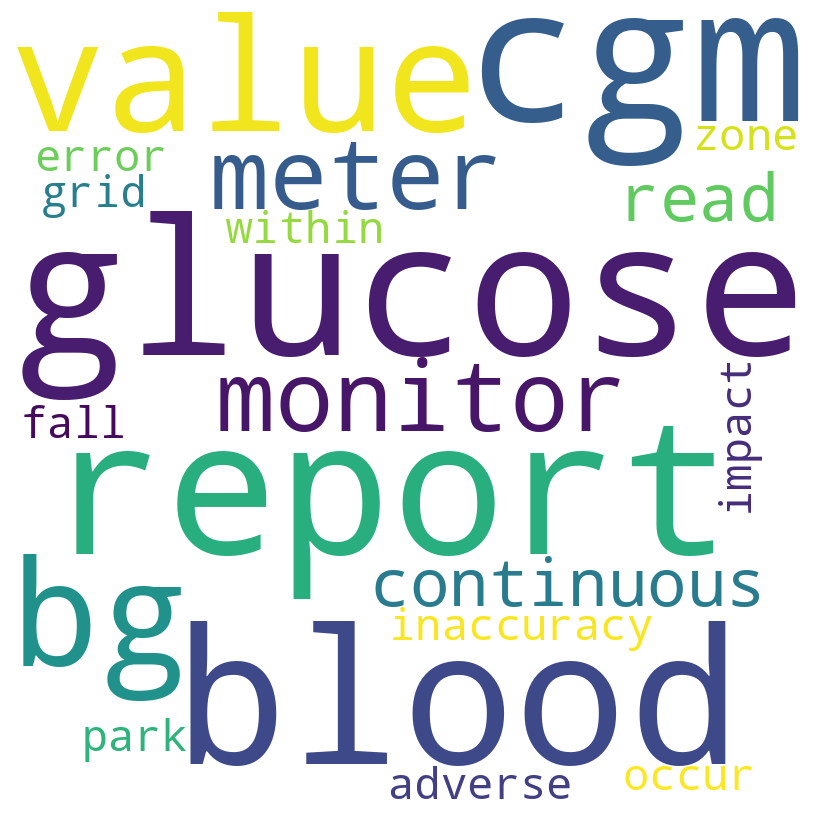

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 14:


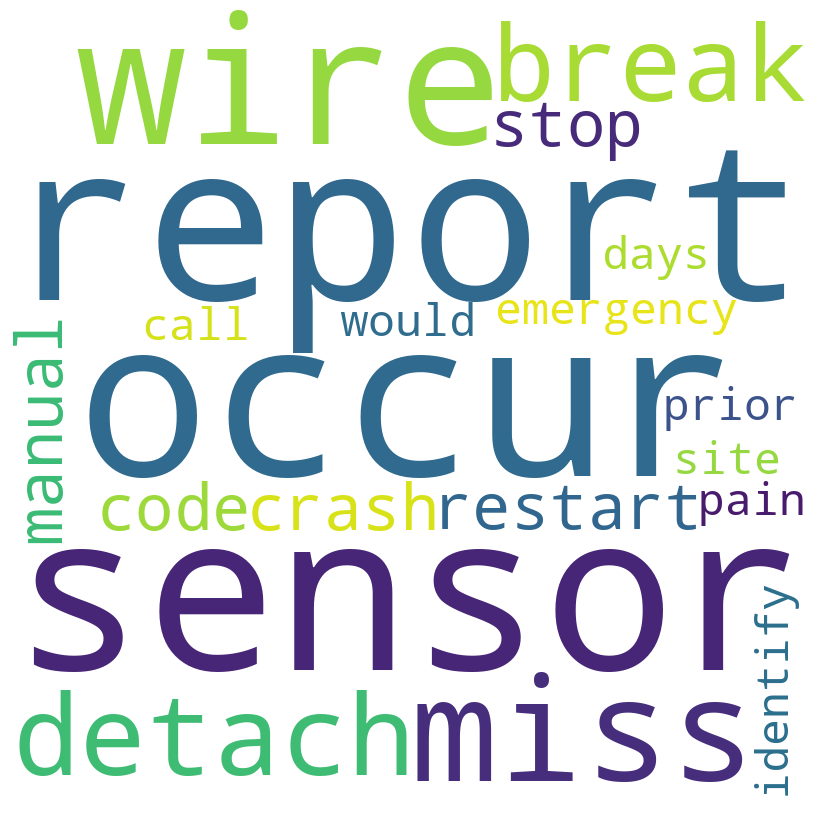

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 15:


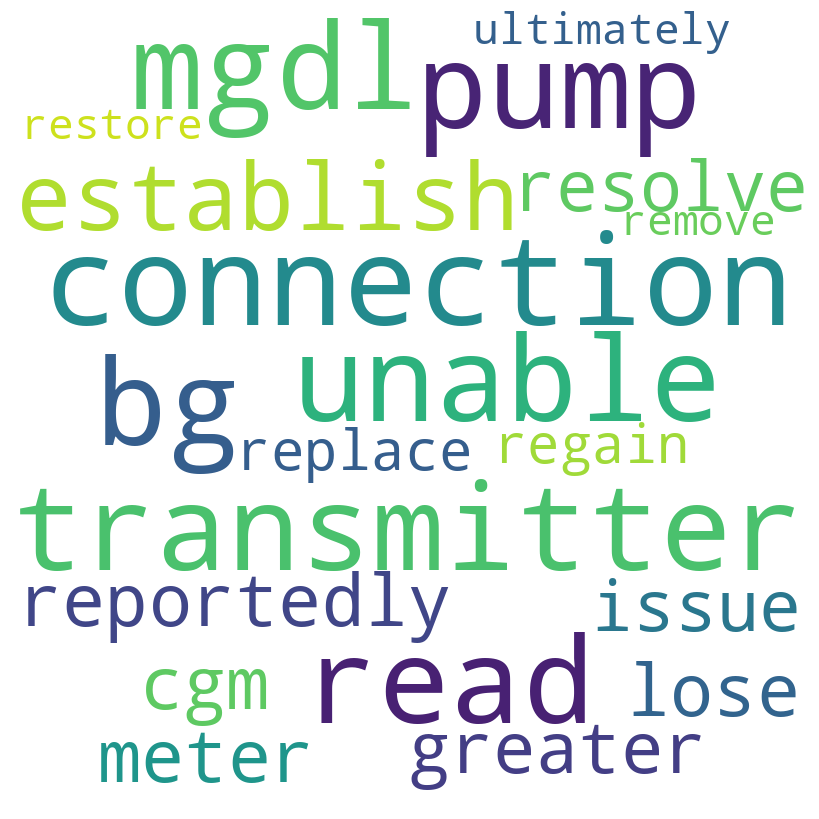

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 16:


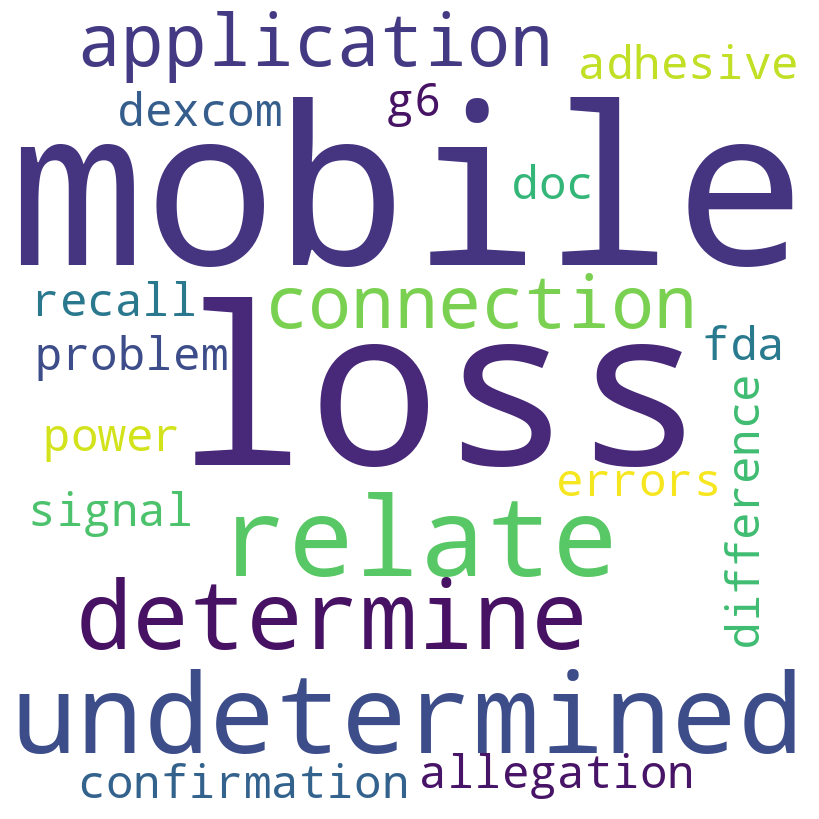

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 17:


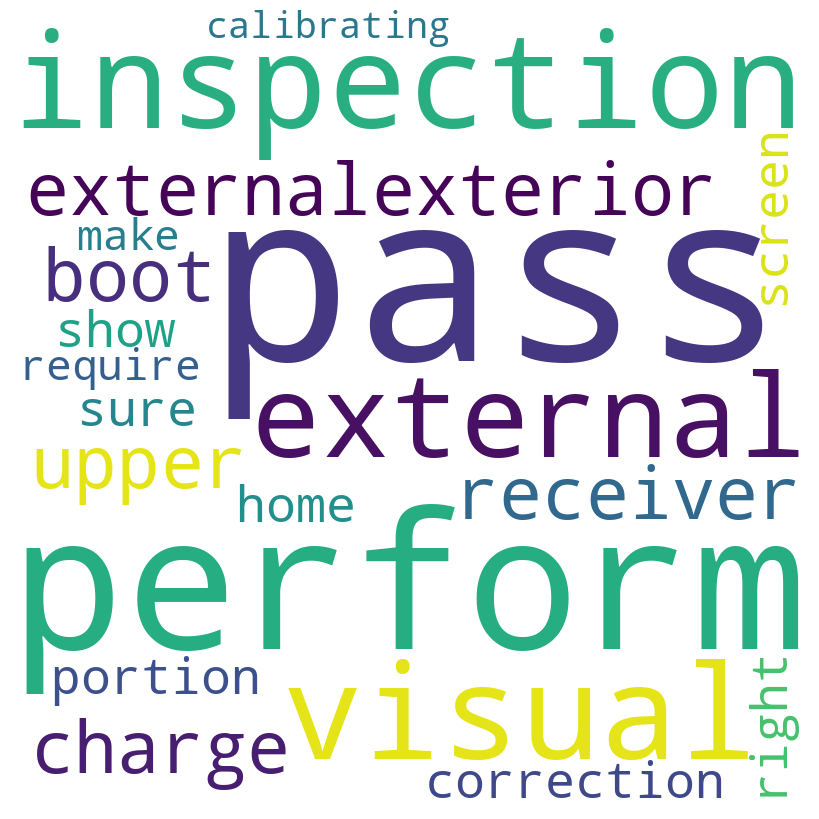

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 18:


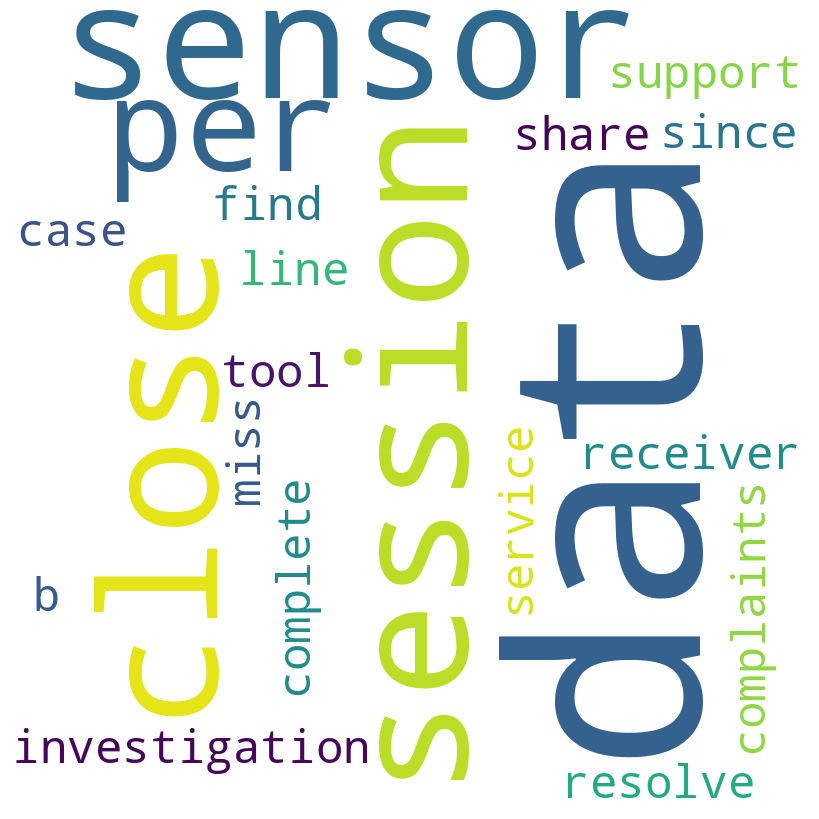

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 19:


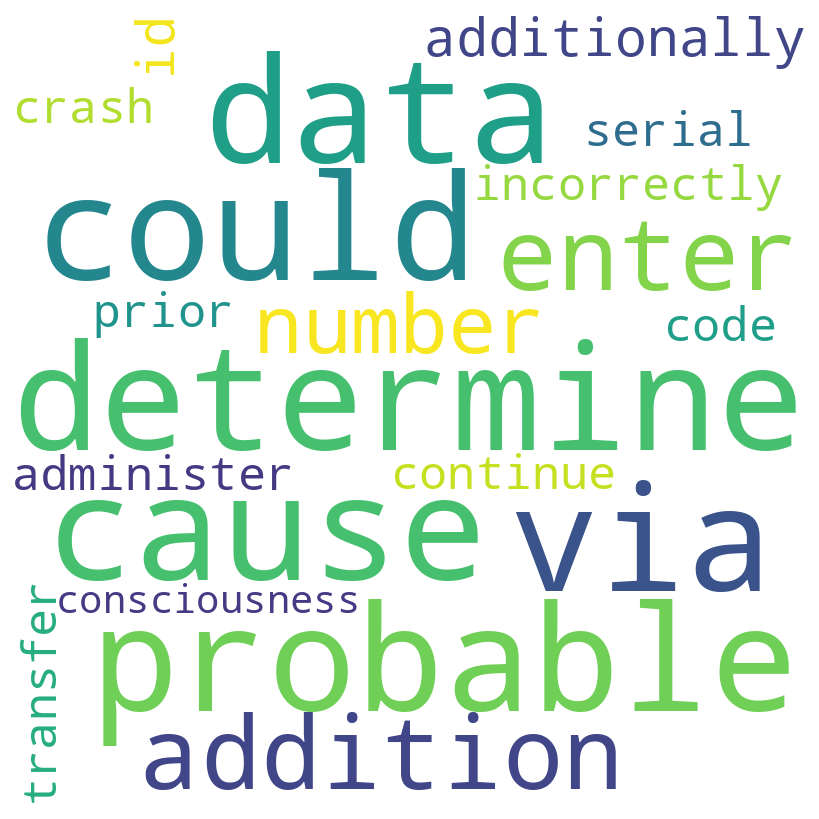

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 20:


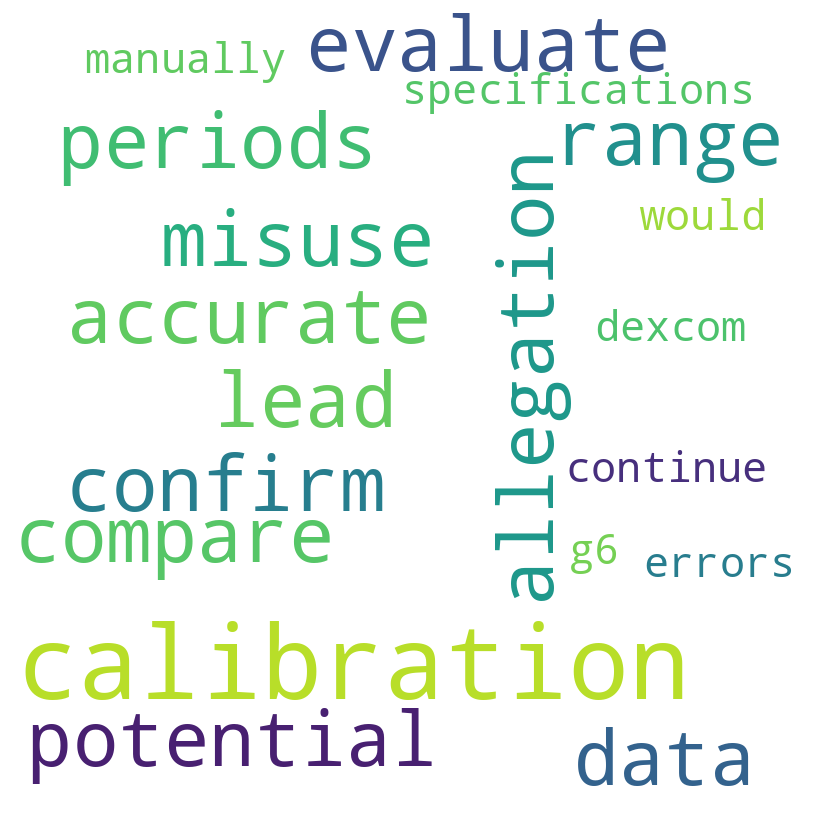

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 21:


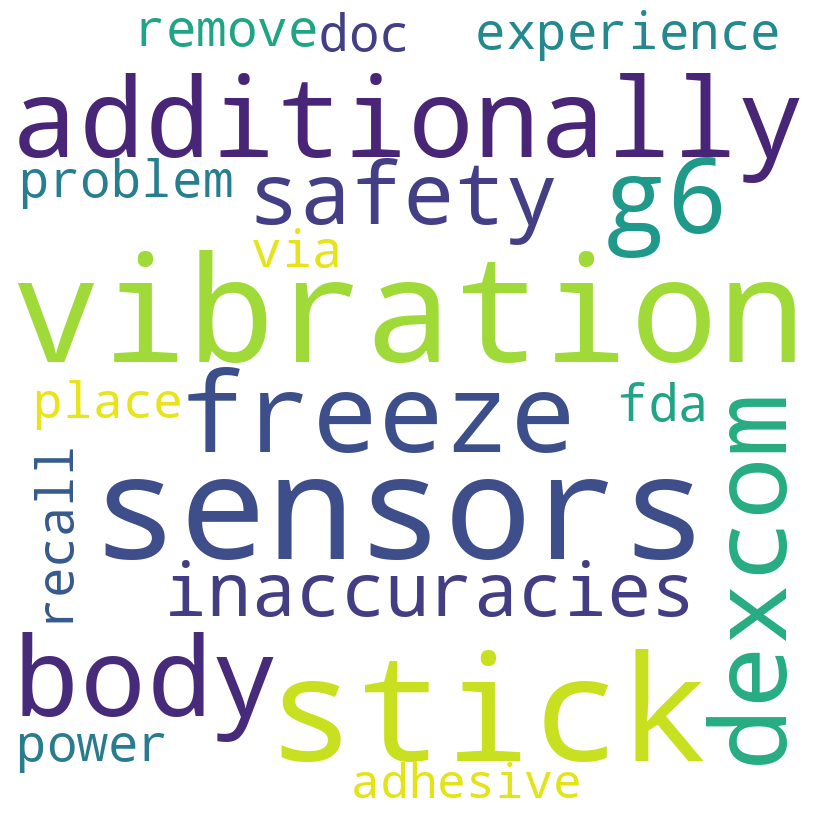

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 22:


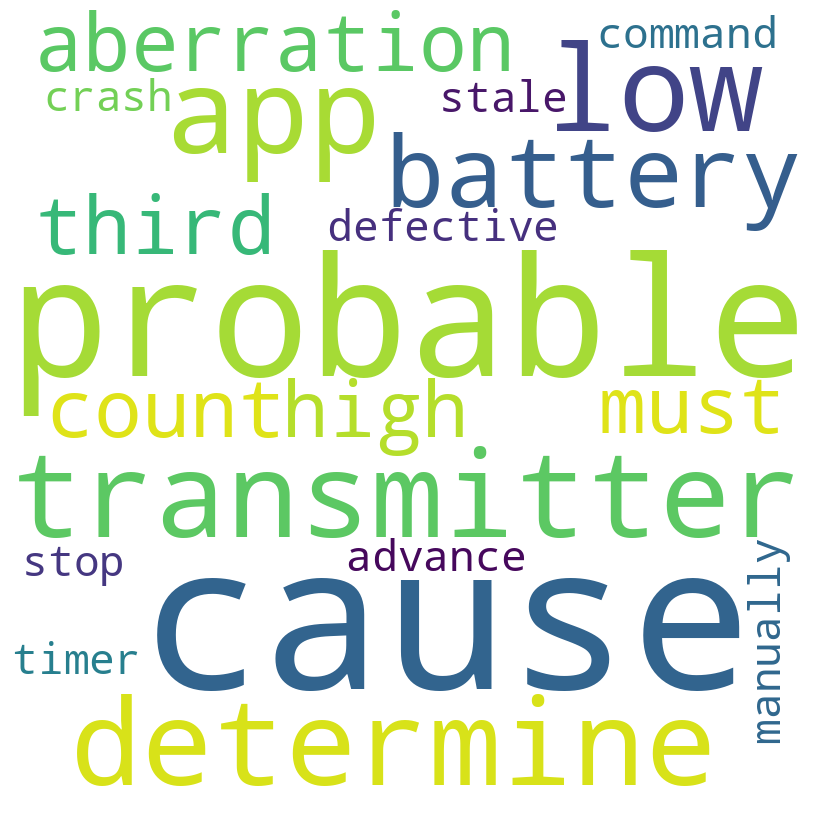

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 23:


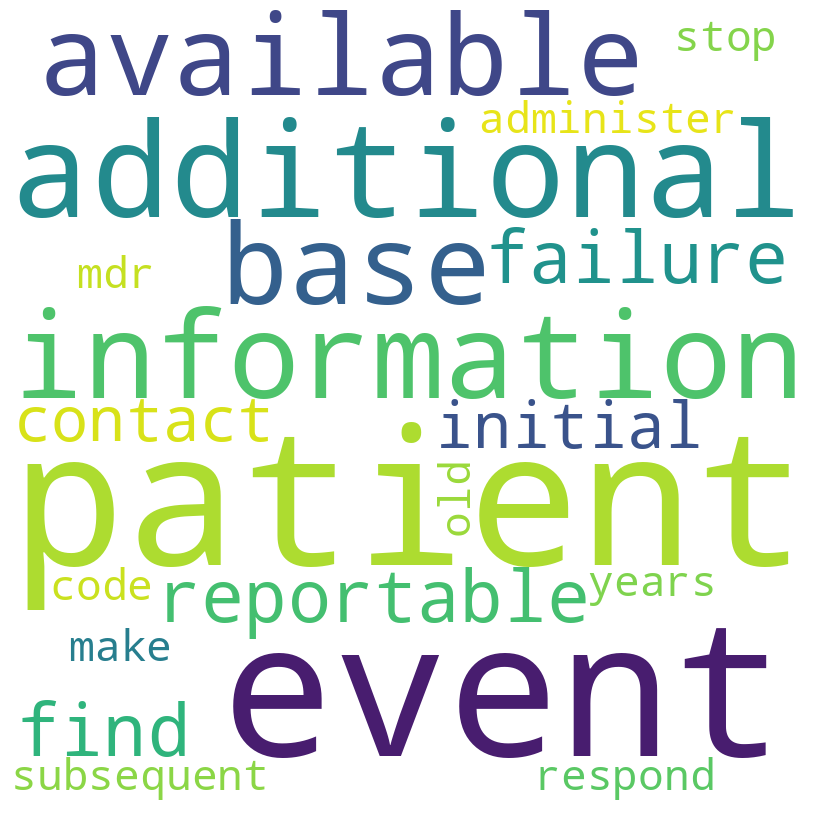

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 24:


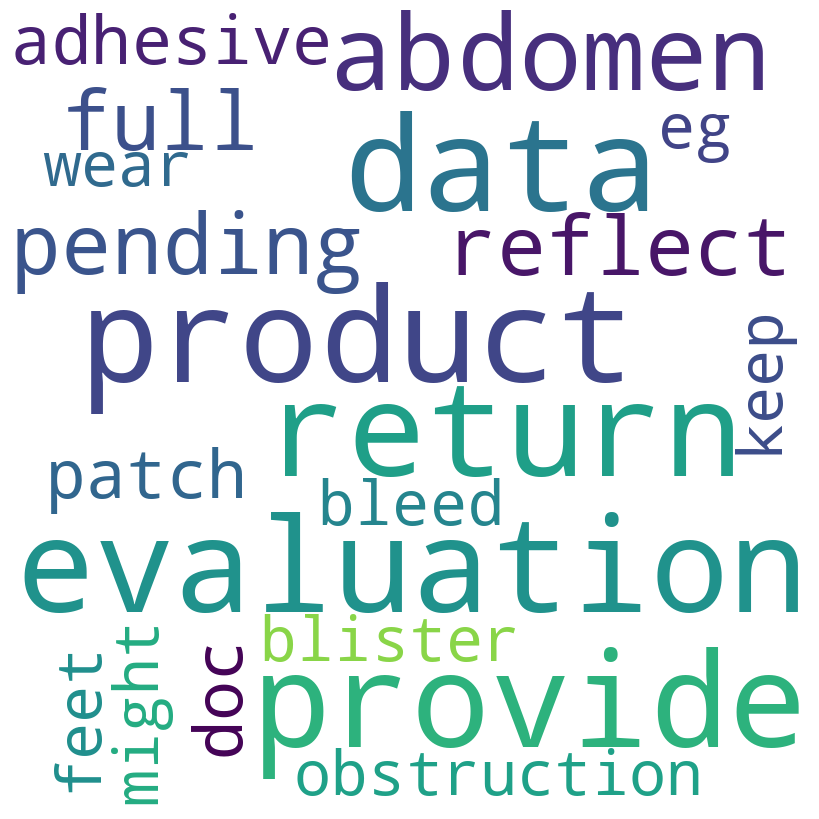

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [93]:
# Generating word clouds for each topic and visualizing 
topics = lda_model.show_topics(num_topics=-1, num_words=20)
for topic in topics:
    print(f"Topic {topic[0]}:")
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(topic[1])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    print("-" * 100)
    print("-" * 100)
    print("-" * 100)

# Analysis with 18 number of topics

In [94]:
import pickle

In [95]:
# Choose the optimal number of topics
num_topics = 18

# Create an LDA model with the optimal number of topics
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics,random_state=21, id2word=dictionary, passes=10)
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
#lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

# Save the LDA model as a pickle file
with open("lda_model.pickle", "wb") as f:
    pickle.dump(lda_model, f)

# Extract the top 10 words for each topic
top_words = lda_model.print_topics(num_topics=num_topics, num_words=10)

# Create a DataFrame to display the top 10 words for each topic
topics_df = pd.DataFrame(columns=["Word " + str(i) for i in range(1, 11)])
for topic_idx, topic in top_words:
    topics_df.loc[topic_idx] = [word for word, _ in lda_model.show_topic(topic_idx, topn=10)]

topics_df.index.name = "Topic"
topics_df.to_pickle("topics_df.pickle")

# Print the top 10 words for each topic
print(topics_df)




            Word 1      Word 2         Word 3      Word 4      Word 5  \
Topic                                                                   
0       connection      report           pump     greater        hour   
1           device     however        operate      within     receive   
2             data  evaluation        product     provide      system   
3           within        find  investigation      review     perform   
4                b      sensor         insert     abdomen         use   
5          perform        pass     inspection      visual        pair   
6        determine       cause          could    probable  allegation   
7           sensor     session       multiple     attempt      unable   
8      transmitter        fail         report       error       occur   
9           return     product     evaluation       issue     replace   
10         perform     voltage           test        pass        fail   
11     information   available         submit      

Topic 0:


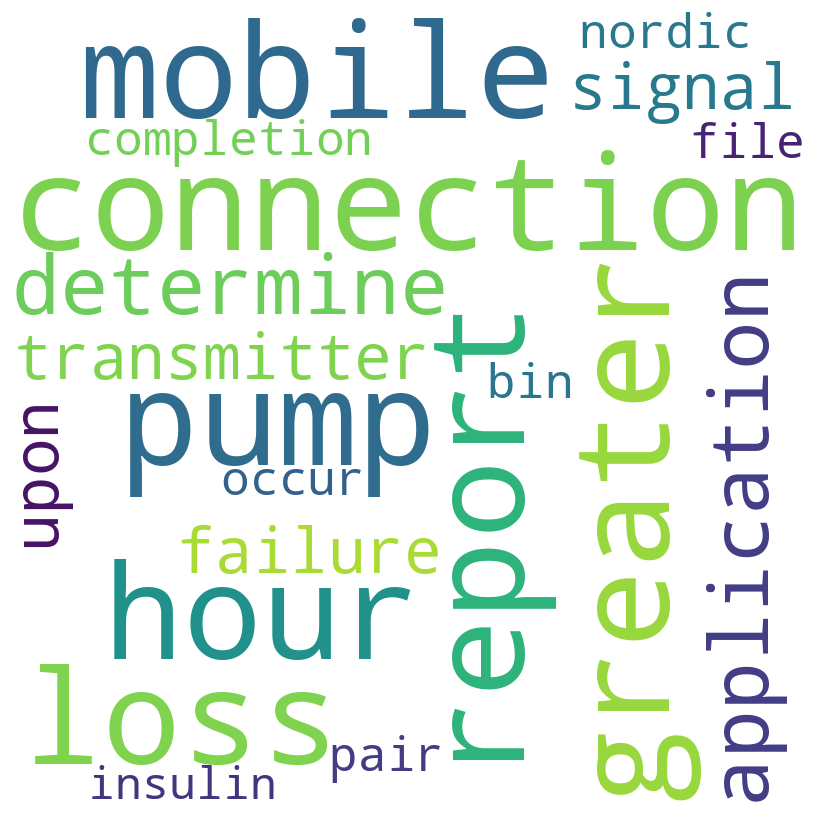

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 1:


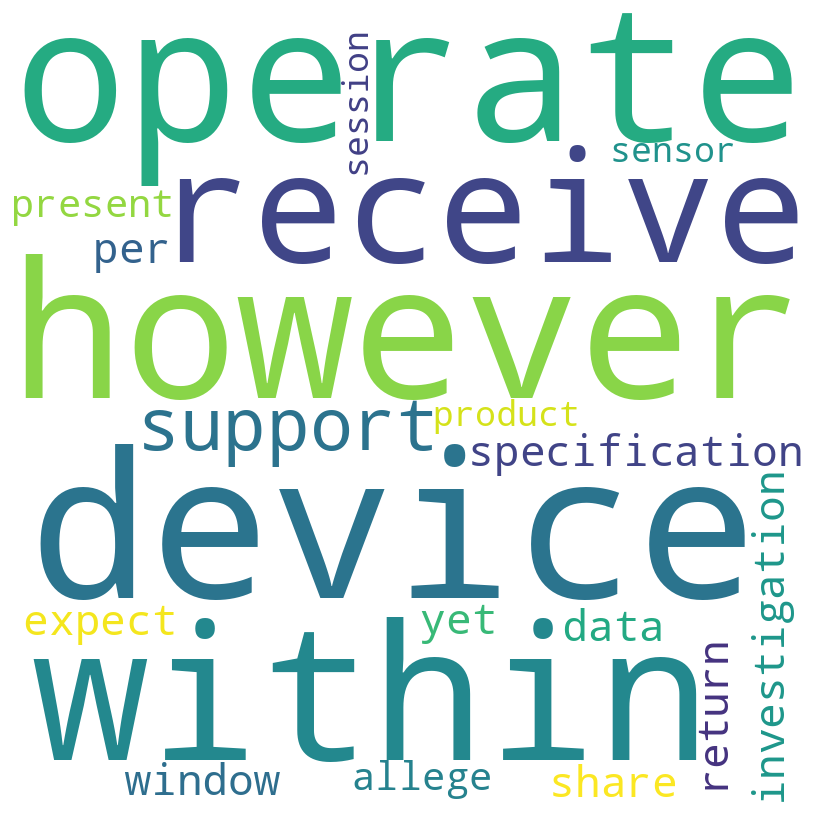

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 2:


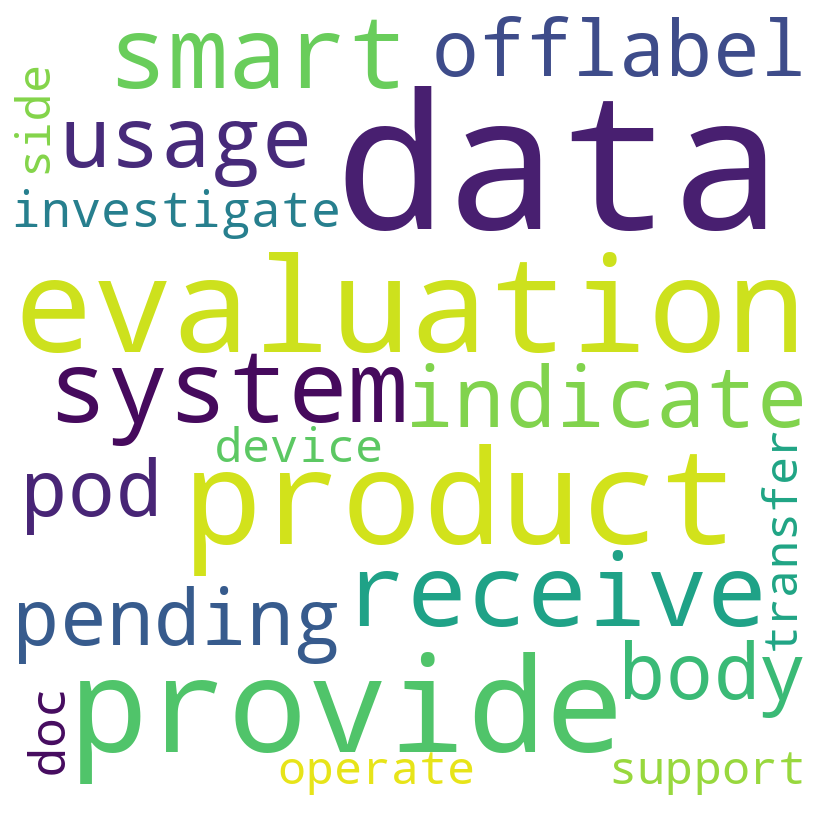

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 3:


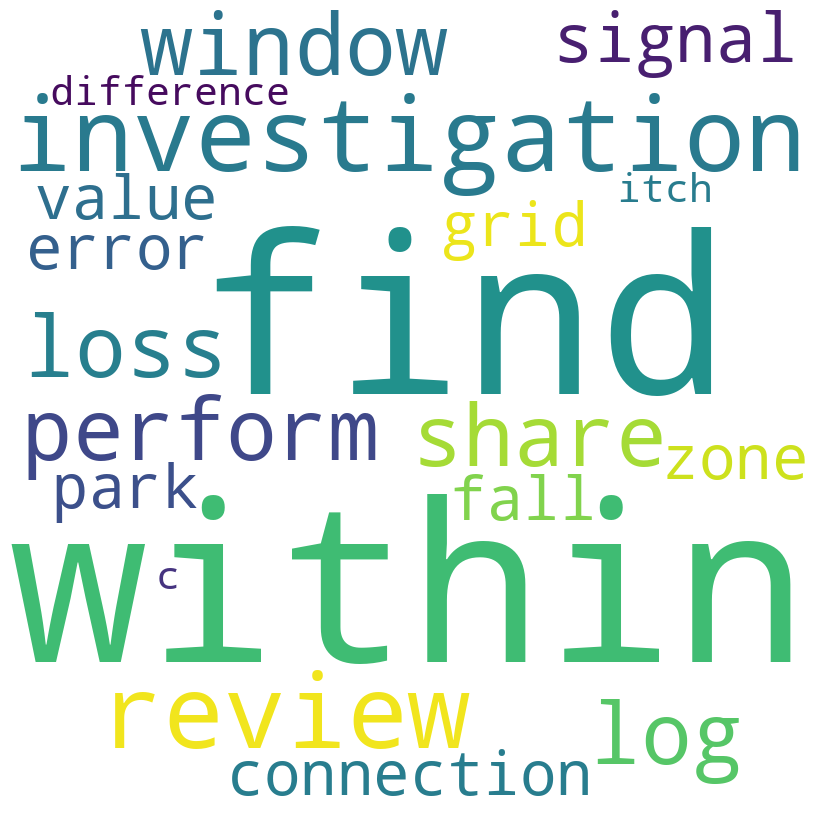

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 4:


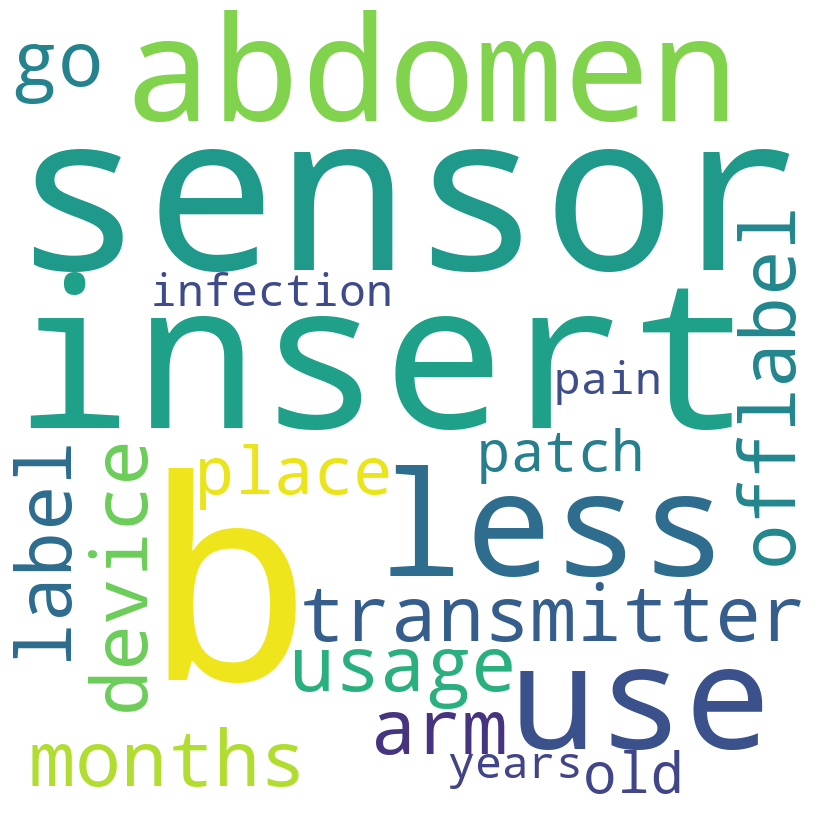

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 5:


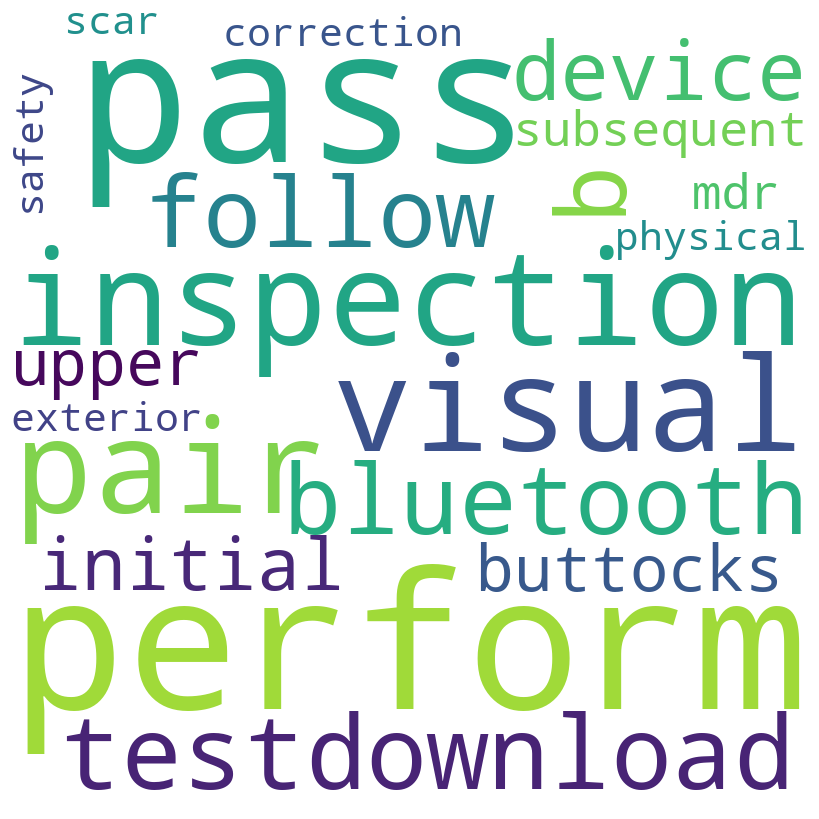

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 6:


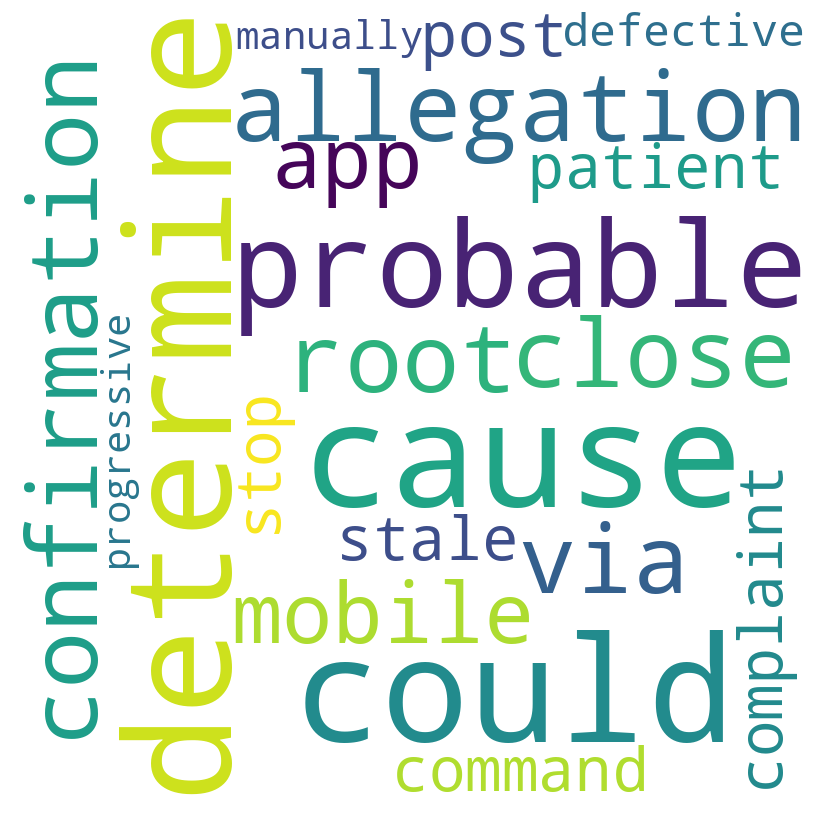

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 7:


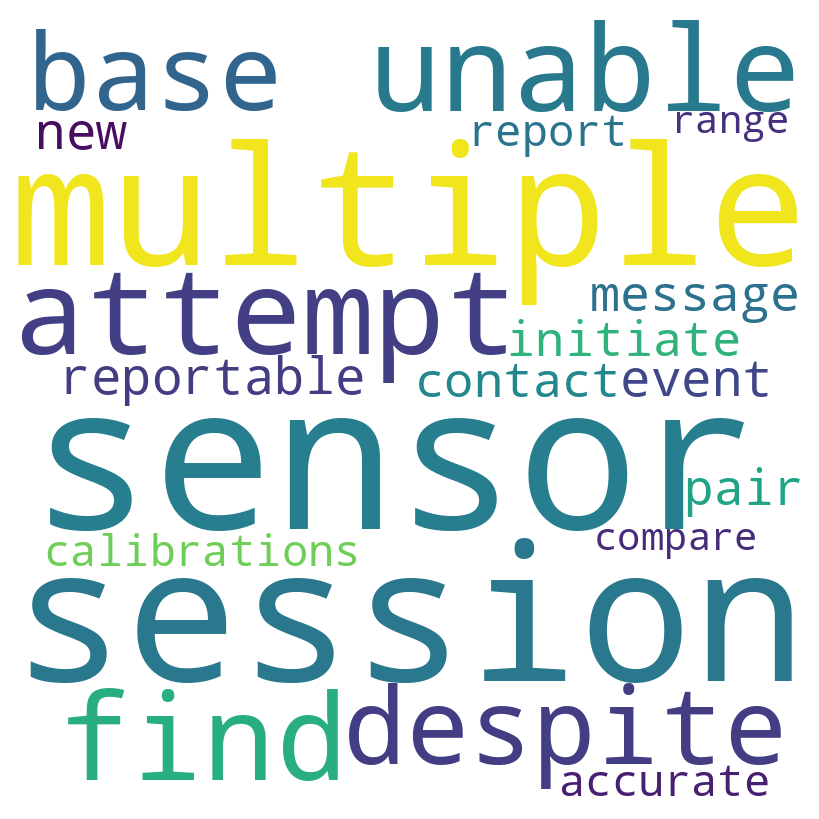

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 8:


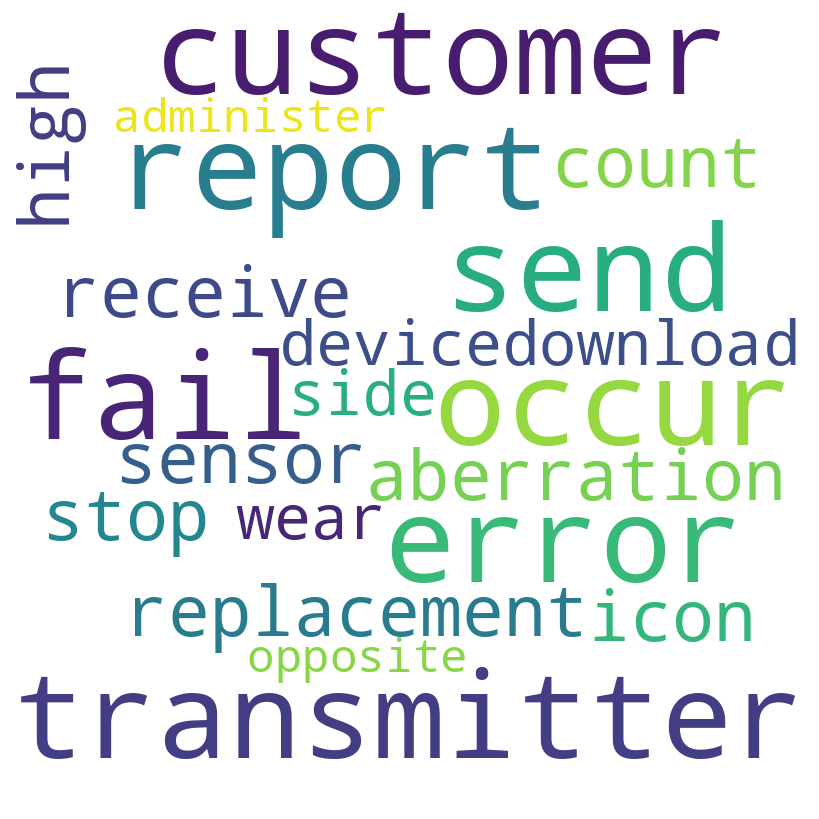

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 9:


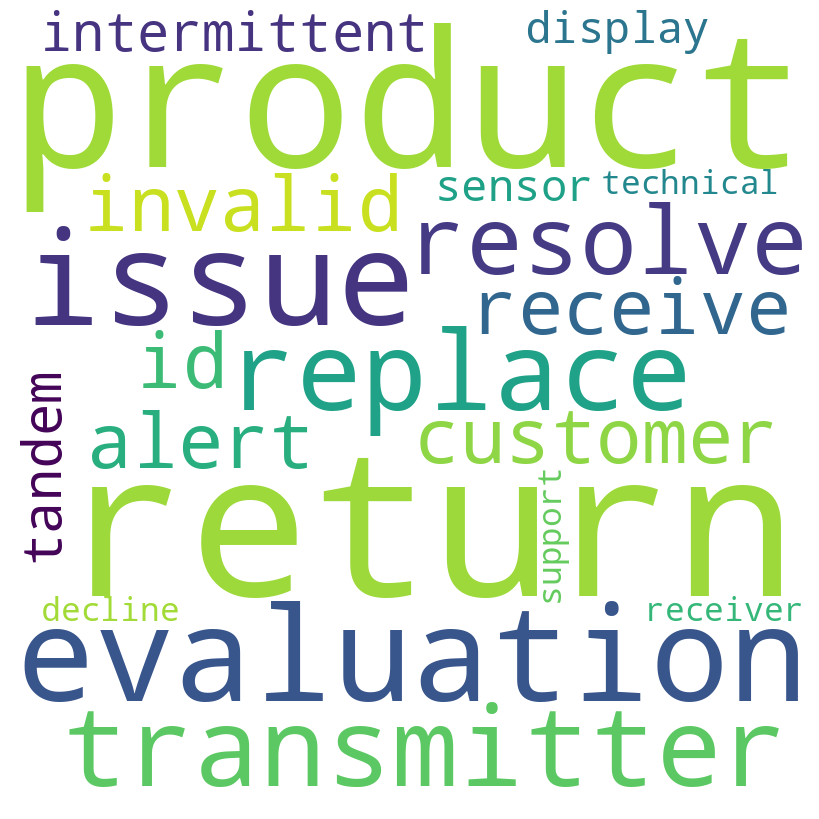

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 10:


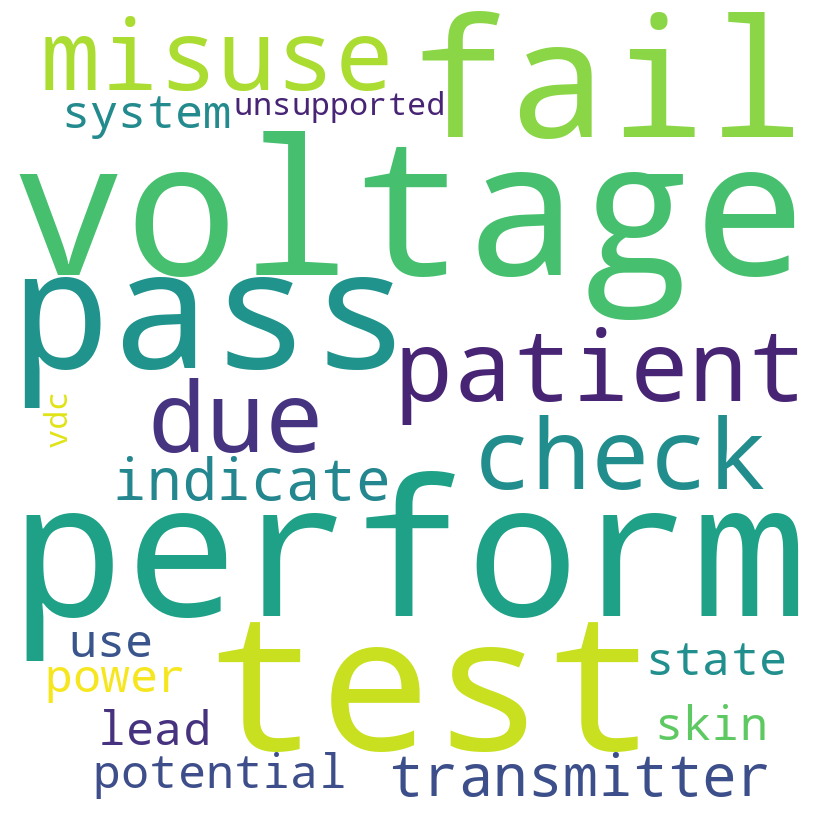

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 11:


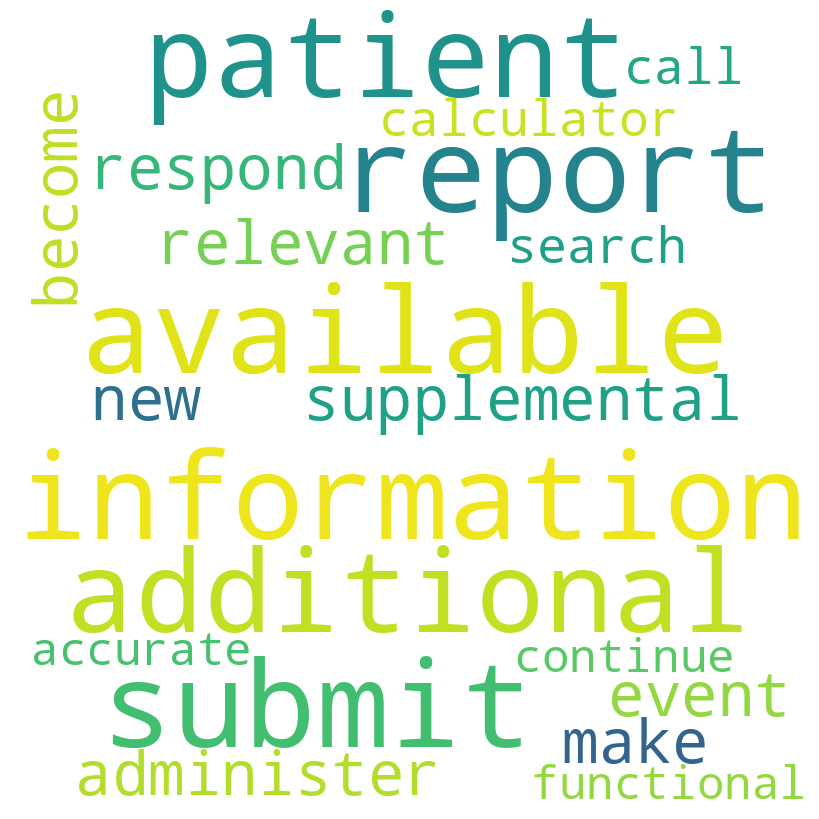

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 12:


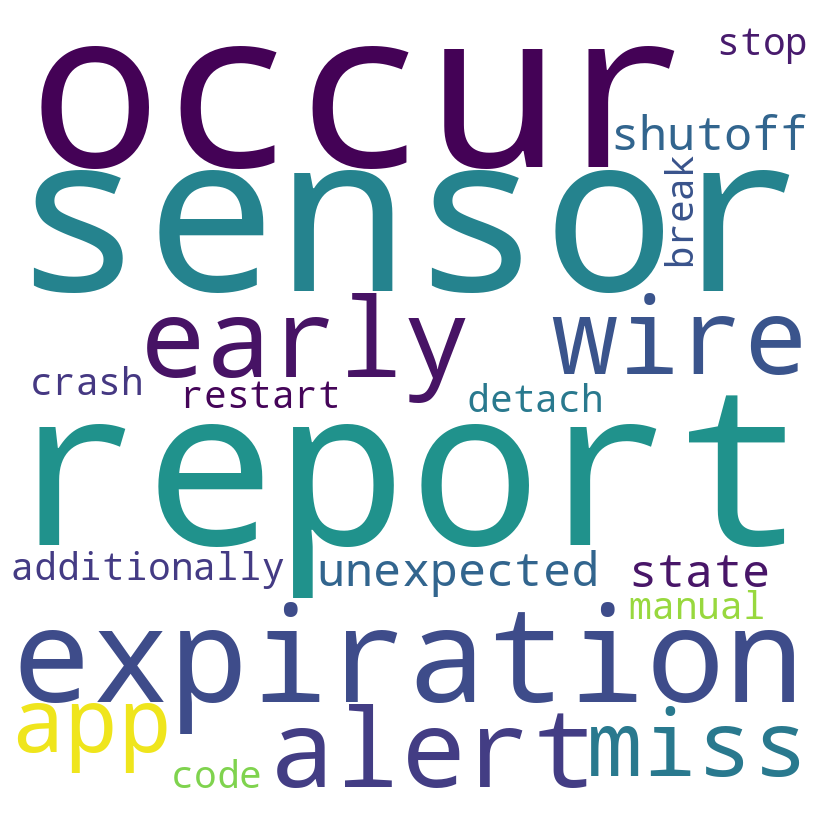

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 13:


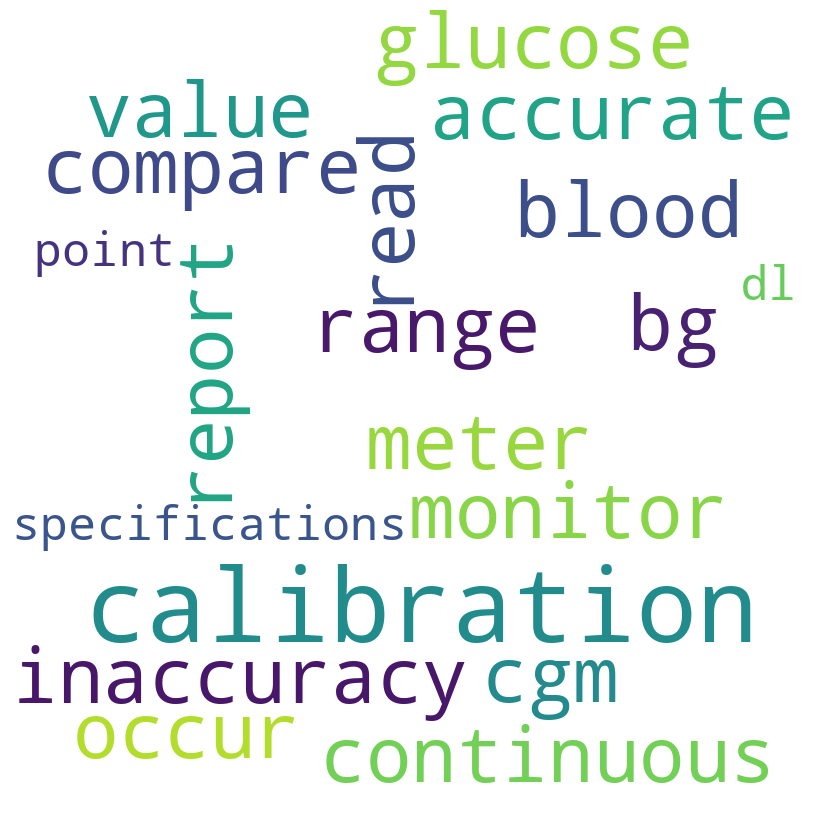

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 14:


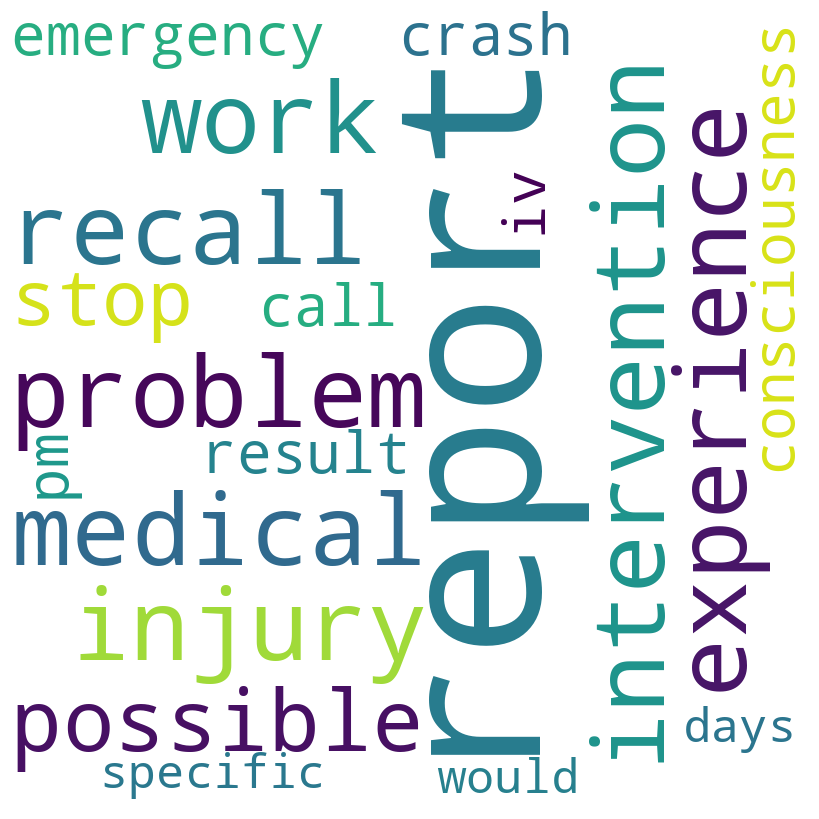

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 15:


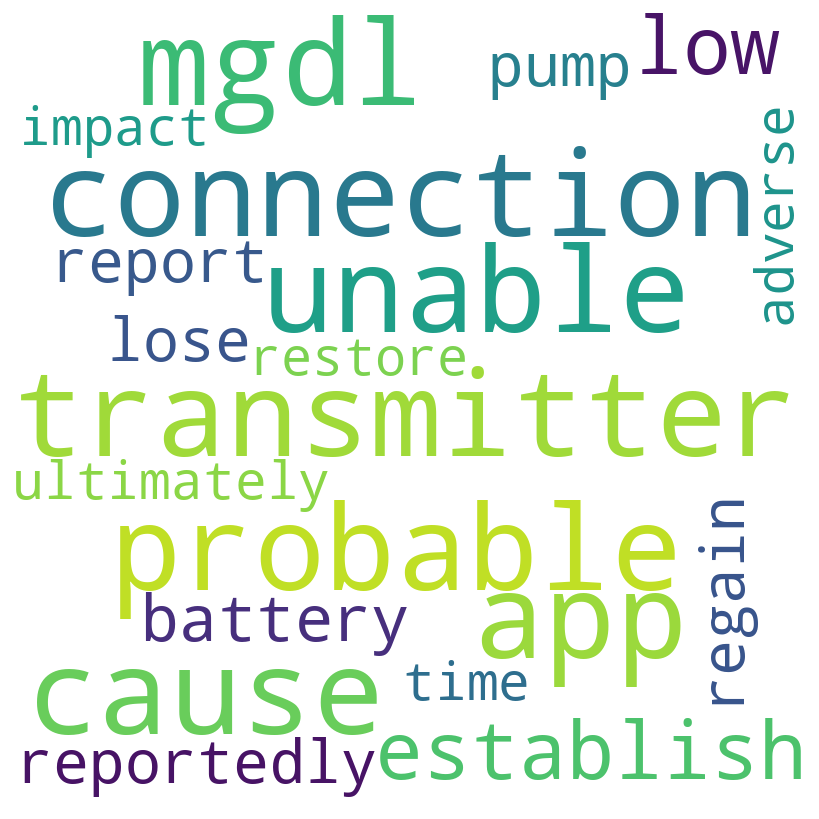

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 16:


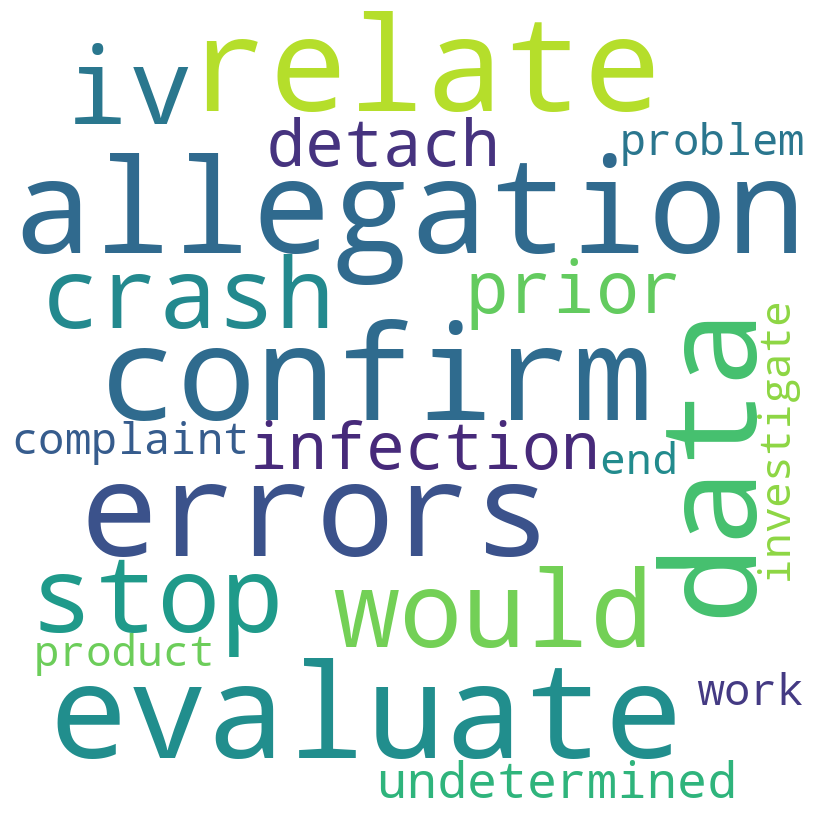

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Topic 17:


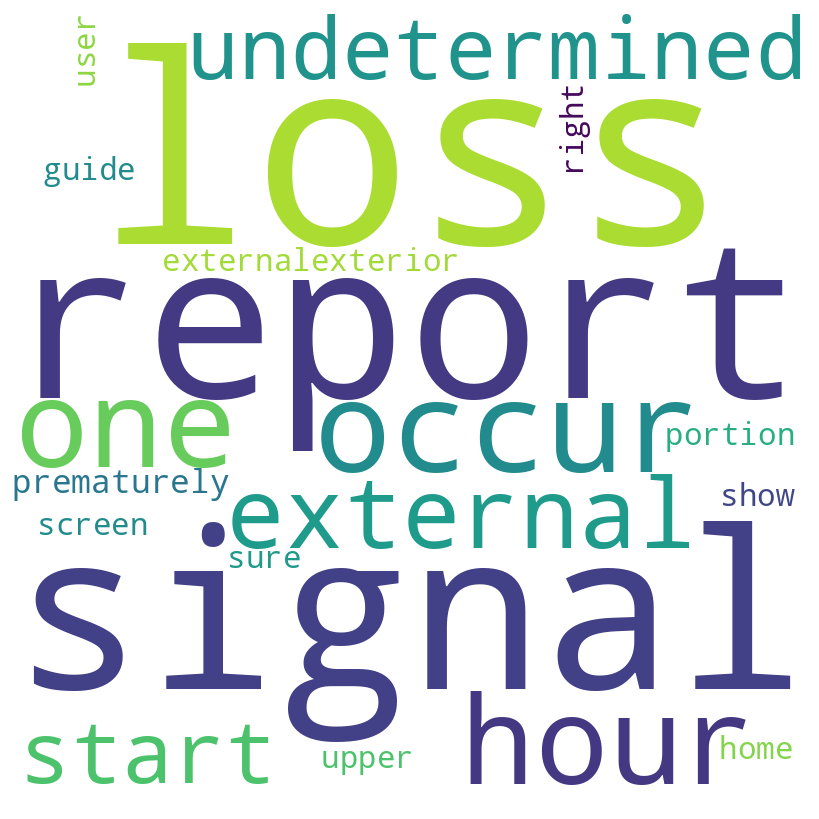

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [96]:
# Generating word clouds for each topic and visualizing 
topics = lda_model.show_topics(num_topics=18, num_words=20)
for topic in topics:
    print(f"Topic {topic[0]}:")
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(topic[1])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    print("-" * 100)
    print("-" * 100)
    print("-" * 100)

# NMF
- NMF (Non-negative Matrix Factorization) is a matrix factorization technique commonly used for unsupervised learning in data science and machine learning. NMF decomposes a non-negative matrix into two non-negative matrices: a basis matrix and a coefficient matrix. The basis matrix represents the fundamental features or patterns in the data, while the coefficient matrix represents the weights of those features for each observation.

- NMF is important because it can be used for dimensionality reduction, feature extraction, and clustering, among other tasks. It is especially useful when dealing with high-dimensional data or data with sparse features. For example, it has been successfully applied in areas such as image processing, text mining, and bioinformatics.

- Performance of NMF is typically evaluated using a metric such as reconstruction error or sparsity. Reconstruction error measures how well the original matrix can be approximated by the product of the basis and coefficient matrices. Sparsity measures the degree to which the basis and coefficient matrices contain mostly zeros. A good NMF model will have a low reconstruction error and high sparsity.

- Interpreting the results of NMF involves examining the basis matrix to understand the fundamental features or patterns in the data. Each row of the basis matrix corresponds to a feature or pattern, and the columns correspond to the original dimensions or variables of the data. The coefficient matrix can be used to understand how strongly each observation is associated with each feature or pattern.


# My concern with the NMF model is that the topic’s “top 10-word” weights add to a number greater than 1. From my research, I believe the weights should add to one.

- If the top word weights for a given topic add up to a number greater than 1, it may be a result of normalization not being applied properly. One common normalization technique for NMF is to divide each row of the coefficient matrix (which represents the weight of each topic for each document) by the sum of its elements. This ensures that the weights for each document sum to 1.

- To address the issue of the top word weights for a given topic summing to a number greater than 1, you could try normalizing the weights for each topic to ensure that they sum to 1. One way to do this is to divide each weight by the sum of all the weights for that topic.

- The NMF weights for each topic are also added to a dataframe nmf_weights_df, which has one row for each topic and one column for each word in the vocabulary. Each element in the dataframe represents the weight of that word in that topic. The weights are normalized so that they sum to 1 for each topic.

In [97]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

In [98]:
# Defining the number of topics to try
min_topics = 1
max_topics = 25
num_top_words = 10
random_state = 42


In [99]:
# Converting the preprocessed sentences to a list
processed_sentences = sentences_df['PROCESSED_SENTENCE'].tolist()

# Creating a TfidfVectorizer object
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_sentences = vectorizer.fit_transform(processed_sentences)

# Creating an empty dataframe to hold the NMF weights
nmf_weights_df = pd.DataFrame()

# Creating an empty dataframe to hold coherence scores
coherence_scores_df = pd.DataFrame(columns=['k', 'Coherence Score'])

for k in range(min_topics, max_topics + 1):
    nmf_model = NMF(
        n_components=k, 
        random_state=random_state, 
        init='nndsvda'
    )
    
    nmf = nmf_model.fit_transform(vectorized_sentences)
    
    vocab = vectorizer.get_feature_names_out()
    
    topics = []
    
    for topic_index, topic in enumerate(nmf_model.components_):
        top_words = [vocab[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(top_words)
        
        # Adding the NMF weights to the dataframe
        nmf_weights = pd.DataFrame(topic).T.add_prefix('Topic_')
        nmf_weights['k'] = k
        nmf_weights_df = nmf_weights_df.append(nmf_weights)
        
    # Normalizing the NMF weights so they sum to 1
    nmf_weights_df.iloc[:, :-1] = nmf_weights_df.iloc[:, :-1].div(
        nmf_weights_df.iloc[:, :-1].sum(axis=1), 
        axis=0
    )
    
    # splitting each sentence into a list of words
    texts = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: nltk.word_tokenize(x)).tolist()
    
    # Creating a dictionary from the words
    dictionary = corpora.Dictionary(texts)
    
    # Creating a bag-of-words representation of the corpus
    corpus = [dictionary.doc2bow(word) for word in texts]
    
    coherence_model = CoherenceModel(
                        topics=topics, 
                        texts=texts, 
                        dictionary=dictionary, 
                        coherence='c_v'
                      )
    
    coherence_score = coherence_model.get_coherence()

    coherence_scores_df = coherence_scores_df.append(
        pd.Series(
            [k, coherence_score], 
            index=['k', 'Coherence Score']
        ), 
        ignore_index=True
    )




In [100]:
# Creating a dataframe of the top 10 words for each topic
top_words_df = pd.DataFrame(topics, columns=[f'word_{i}' for i in range(num_top_words)])

In [101]:
top_words_df

word_0        word_1         word_2        word_3         word_4  \
0         injury  intervention        medical        report        adverse   
1       probable     determine          cause          data     allegation   
2           hour        signal           loss         occur         report   
3        confirm    allegation           data  undetermined        message   
4        provide    evaluation           data       product  investigation   
5           fail         error    transmitter         occur         report   
6         review           log          share        window  investigation   
7     additional       patient          event     available    information   
8       evaluate          data        product  undetermined  investigation   
9   supplemental        submit       relevant           new      available   
10        return       product     evaluation      evaluate         expect   
11       glucose    continuous        monitor         blood     inaccuracy   
12   replacement          send       customer   transmitter         sensor   
13          root     determine          cause   application         relate   
14        visual    inspection           pass      external        perform   
15           app        unable      establish    connection    transmitter   
16       receive        device         expect      customer         submit   
17  confirmation    allegation   undetermined     determine          issue   
18        sensor        insert        abdomen    expiration          early   
19         value          fall           park          grid           zone   
20       voltage          test        perform          pass           fail   
21       battery           low    transmitter        months            use   
22        device       operate  specification      indicate          smart   
23          read          mgdl             bg    reportedly            cgm   
24    connection          pump           lose       greater    transmitter   

              word_5      word_6        word_7       word_8         word_9  
0              occur      impact    expiration        alert          early  
1             mobile   defective     potential       signal           loss  
2        application      relate        mobile   expiration          early  
3              early    addition    expiration      greater        problem  
4            receive     pending      complete      support        session  
5           customer     receive           use   reportable           base  
6            perform        loss        signal   connection         allege  
7              close      mobile        misuse   reportable           base  
8            session     support       greater      message       complete  
9        information      report       perform       device     evaluation  
10            allege      device       present      pending         window  
11             meter         cgm          read           bg         report  
12                id     invalid           use      receive          enter  
13            mobile        loss    connection      servers         signal  
14  externalexterior        pair  testdownload    bluetooth       exterior  
15          probable       cause        mobile      restore          close  
16      supplemental  evaluation         alert           id        invalid  
17         complaint  connection      addition         base     reportable  
18             occur      report       session      replace           wire  
19             error     glucose    difference       report  investigation  
20              pair       check           vdc  measurement      bluetooth  
21             alert     replace         issue      resolve             id  
22             usage     support      offlabel       expect         return  
23             meter      second            dl          use          value  
24              hour      regain        report   ultimat

In [102]:
# Joining the coherence scores dataframe with the top words dataframe
coherence_scores_df = coherence_scores_df.merge(top_words_df, left_index=True, right_index=True)

In [103]:
coherence_scores_df

k  Coherence Score        word_0        word_1         word_2  \
0    1.0         0.238430        injury  intervention        medical   
1    2.0         0.296573      probable     determine          cause   
2    3.0         0.367531          hour        signal           loss   
3    4.0         0.355143       confirm    allegation           data   
4    5.0         0.363866       provide    evaluation           data   
5    6.0         0.395155          fail         error    transmitter   
6    7.0         0.425081        review           log          share   
7    8.0         0.421012    additional       patient          event   
8    9.0         0.408424      evaluate          data        product   
9   10.0         0.396681  supplemental        submit       relevant   
10  11.0         0.382112        return       product     evaluation   
11  12.0         0.423550       glucose    continuous        monitor   
12  13.0         0.417776   replacement          send       customer   
13  14.0         0.425752          root     determine          cause   
14  15.0         0.416218        visual    inspection           pass   
15  16.0         0.407927           app        unable      establish   
16  17.0         0.407589       receive        device         expect   
17  18.0         0.403867  confirmation    allegation   undetermined   
18  19.0         0.418159        sensor        insert        abdomen   
19  20.0         0.442512         value          fall           park   
20  21.0         0.449738       voltage          test        perform   
21  22.0         0.437707       battery           low    transmitter   
22  23.0         0.431121        device       operate  specification   
23  24.0         0.448287          read          mgdl             bg   
24  25.0         0.447310    connection          pump           lose   

          word_3         word_4            word_5      word_6        word_7  \
0         report        adverse             occur      impact    expiration   
1           data     allegation            mobile   defective     potential   
2          occur         report       application      relate        mobile   
3   undetermined        message             early    addition    expiration   
4        product  investigation           receive     pending      complete   
5          occur         report          customer     receive           use   
6         window  investigation           perform        loss        signal   
7      available    information             close      mobile        misuse   
8   undetermined  investigation           session     support       greater   
9            new      available       information      report       perform   
10      evaluate         expect            allege      device       present   
11         blood     inaccuracy             meter         cgm          read   
12   transmitter         sensor                id     invalid           use   
13   application         relate            mobile        loss    connection   
14      external        perform  externalexterior        pair  testdownload   
15    connection    transmitter          probable       cause        mobile   
16      customer         submit      supplemental  evaluation         alert   
17     determine          issue         complaint  connection      addition   
18    expiration          early             occur      report       session   
19          grid           zone             error     glucose    difference   
20          pass           fail              pair       check           vdc   
21        months            use             alert     replace         issue   
22      indicate          smart             usage     support      offlabel   
23    reportedly            cgm             meter      second            dl   
24       greater    transmitter              hour      regain        report   

         word_8         word_9  
0         alert          early  
1        sign

In [104]:
print(nmf_weights_df)

         Topic_0   Topic_1       Topic_2   Topic_3       Topic_4  \
0   2.900162e-07  0.000027  5.606506e-09  0.000002  5.026840e-07   
0   2.889639e-07  0.000026  4.265018e-09  0.000000  1.617504e-07   
0   8.946238e-08  0.000027  4.444425e-08  0.000282  2.081707e-05   
0   0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000e+00   
0   0.000000e+00  0.000019  4.457408e-08  0.000296  2.166158e-05   
..           ...       ...           ...       ...           ...   
0   7.808211e-06  0.000000  0.000000e+00  0.000000  0.000000e+00   
0   7.260919e-06  0.000000  0.000000e+00  0.001944  0.000000e+00   
0   2.071132e-06  0.000000  1.492478e-06  0.000000  4.590846e-06   
0   0.000000e+00  0.000000  1.577787e-07  0.000000  2.702875e-05   
0   0.000000e+00  0.000000  0.000000e+00  0.000000  4.580499e-05   

         Topic_5       Topic_6   Topic_7       Topic_8   Topic_9  ...  \
0   3.717690e-06  2.454243e-07  0.000071  1.770630e-08  0.000002  ...   
0   3.757521e-06  2.270804e-07  0.000

In [105]:
# Checking if the sum of all coefficients of a NMF model for each topic sums to greater than 1 or not
print(np.allclose(nmf_weights_df.iloc[:, :-1].sum(axis=1), 1.0))

True
